In [1]:
# Cell 1: Import Libraries and Initial Setup
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
tf.get_logger().setLevel('ERROR')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU(s) available: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("\nNo GPU available, using CPU")

E0000 00:00:1761932245.881520      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761932246.010580      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!
TensorFlow version: 2.18.0
Librosa version: 0.11.0

GPU(s) available: 2
  - /physical_device:GPU:0
  - /physical_device:GPU:1


In [2]:
# Cell 2: Load Dataset Paths and Labels
paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input/voicedata'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print(f'Dataset is Loaded')
print(f'Total samples: {len(paths)}')
print(f'Total labels: {len(labels)}')

Dataset is Loaded
Total samples: 2800
Total labels: 2800


In [3]:
# Cell 3: Create DataFrame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

print("DataFrame created:")
print(df.head(10))
print(f"\nDataFrame shape: {df.shape}")

DataFrame created:
                                              speech label
0  /kaggle/input/voicedata/TESS Toronto emotional...  fear
1  /kaggle/input/voicedata/TESS Toronto emotional...  fear
2  /kaggle/input/voicedata/TESS Toronto emotional...  fear
3  /kaggle/input/voicedata/TESS Toronto emotional...  fear
4  /kaggle/input/voicedata/TESS Toronto emotional...  fear
5  /kaggle/input/voicedata/TESS Toronto emotional...  fear
6  /kaggle/input/voicedata/TESS Toronto emotional...  fear
7  /kaggle/input/voicedata/TESS Toronto emotional...  fear
8  /kaggle/input/voicedata/TESS Toronto emotional...  fear
9  /kaggle/input/voicedata/TESS Toronto emotional...  fear

DataFrame shape: (2800, 2)


In [4]:
# Cell 4: Check Label Distribution
print("Label Distribution:")
print(df['label'].value_counts())
print("\nLabel percentages:")
print(df['label'].value_counts(normalize=True) * 100)

Label Distribution:
label
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64

Label percentages:
label
fear       14.285714
angry      14.285714
disgust    14.285714
neutral    14.285714
sad        14.285714
ps         14.285714
happy      14.285714
Name: proportion, dtype: float64


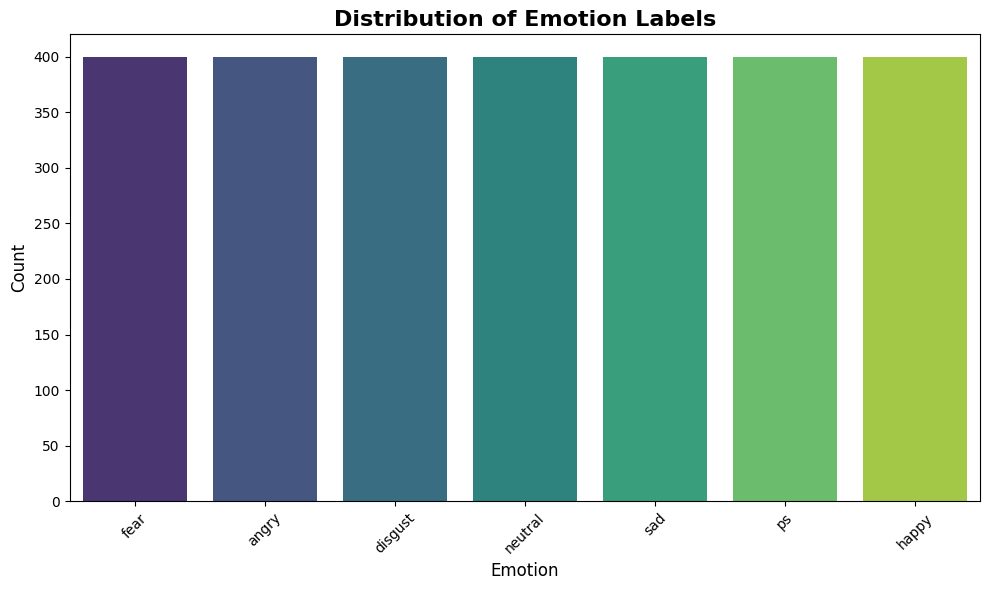

In [5]:
# Cell 5: Visualize Label Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of Emotion Labels', fontsize=16, fontweight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Define Visualization Functions
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f'Waveform - {emotion}', size=20, fontweight='bold')
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(f'Spectrogram - {emotion}', size=20, fontweight='bold')
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


Sampling Rate: 22050 Hz
Duration: 1.40 seconds


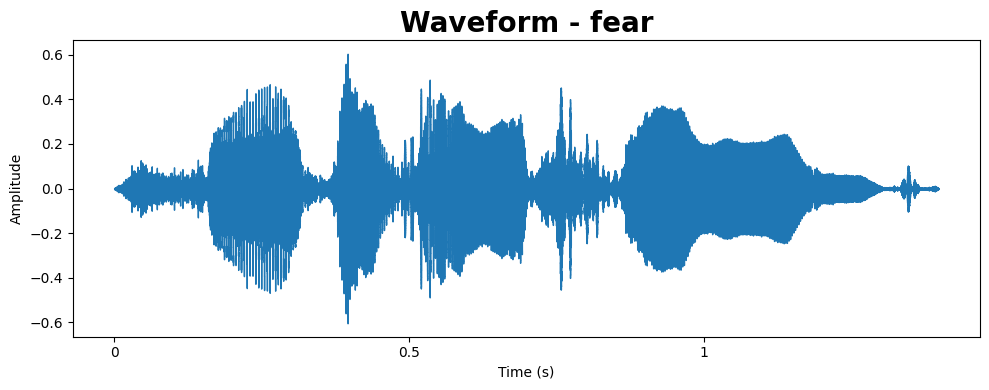

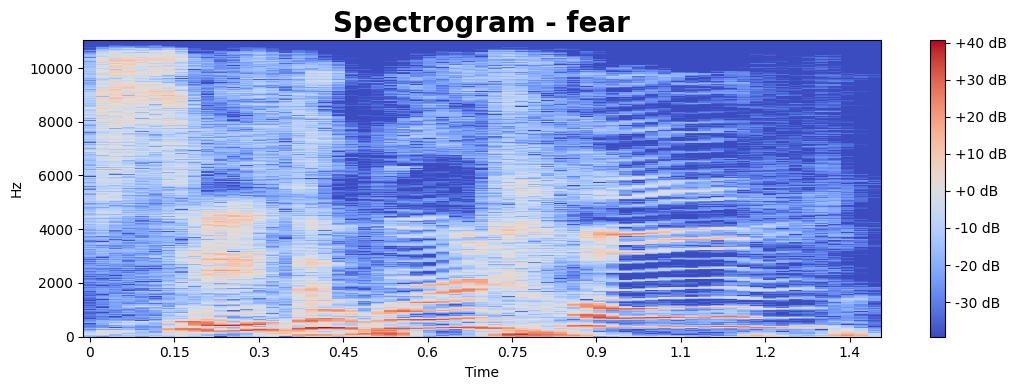

In [7]:
# Cell 7: Visualize Fear Emotion
emotion = 'fear'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
print(f"Sampling Rate: {sampling_rate} Hz")
print(f"Duration: {len(data)/sampling_rate:.2f} seconds")
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

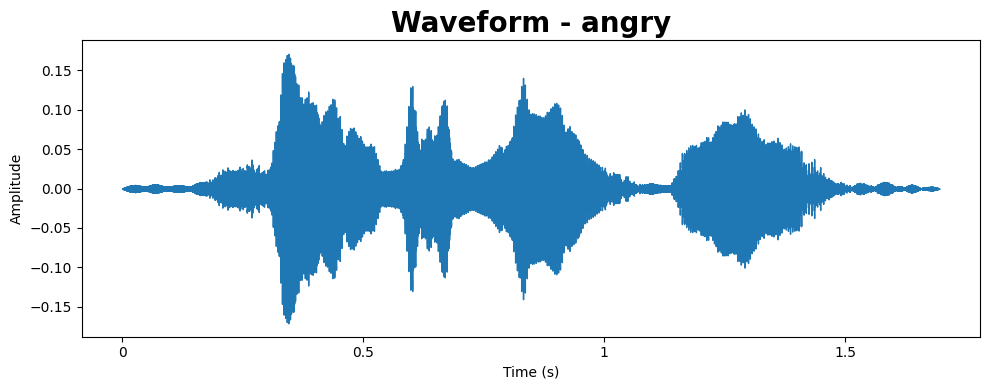

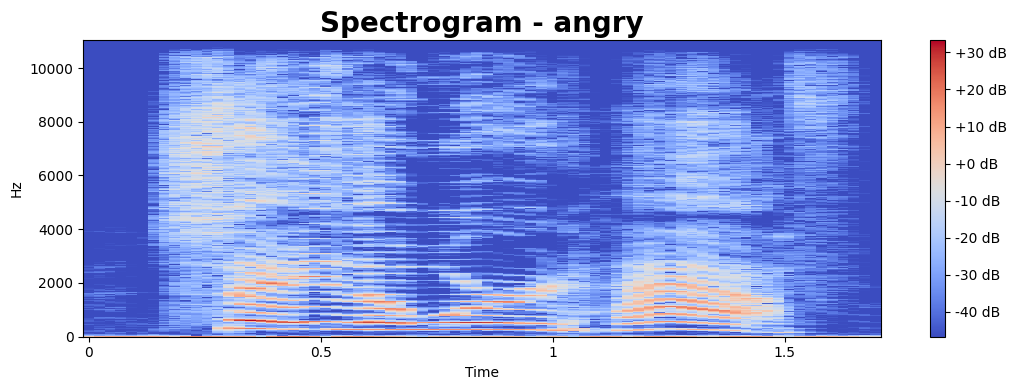

In [8]:
# Cell 8: Visualize Angry Emotion
emotion = 'angry'
path = np.array(df['speech'][df['label'] == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

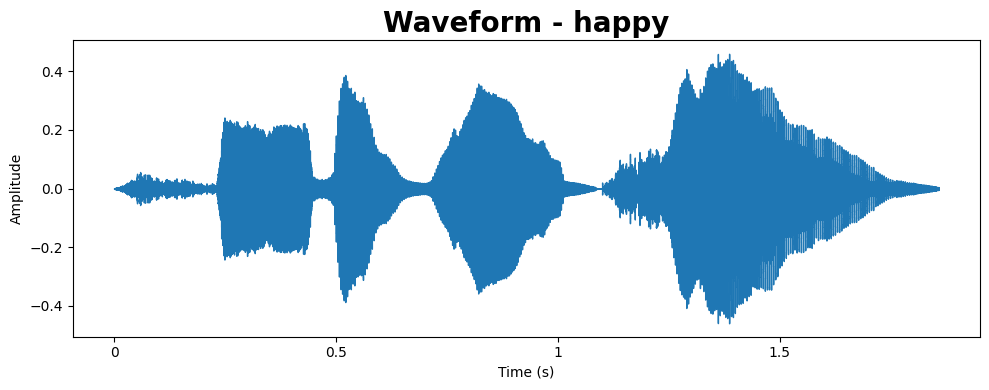

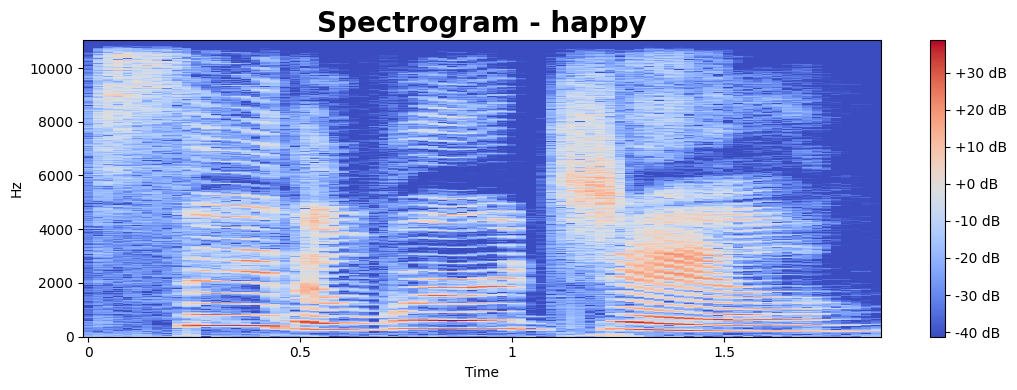

In [9]:
# Cell 9: Visualize Happy Emotion
emotion = 'happy'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [10]:
# Cell 10: Enhanced Feature Extraction Function
def extract_features(filename, duration=2.5, offset=0.6):
    """
    Extract multiple audio features for better emotion recognition
    """
    try:
        # Load audio file
        y, sr = librosa.load(filename, duration=duration, offset=offset)
        
        # Feature 1: MFCCs (Mel Frequency Cepstral Coefficients)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        
        # Feature 2: Chroma (Pitch class representation)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        
        # Feature 3: Mel Spectrogram
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
        
        # Feature 4: Spectral Contrast
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        
        # Feature 5: Tonnetz (Tonal centroid features)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        
        # Feature 6: Zero Crossing Rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
        
        # Feature 7: Root Mean Square Energy
        rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
        
        # Combine all features
        features = np.hstack([mfcc, chroma, mel, contrast, tonnetz, zcr, rms])
        
        return features
    
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

print("Enhanced feature extraction function defined!")
print("Features include: MFCCs, Chroma, Mel Spectrogram, Spectral Contrast, Tonnetz, ZCR, RMS")

Enhanced feature extraction function defined!
Features include: MFCCs, Chroma, Mel Spectrogram, Spectral Contrast, Tonnetz, ZCR, RMS


In [11]:
# Cell 11: Test Feature Extraction on a Sample
sample_features = extract_features(df['speech'][0])
print(f"Sample feature shape: {sample_features.shape}")
print(f"Total features extracted: {len(sample_features)}")
print(f"\nFirst 10 features: {sample_features[:10]}")

Sample feature shape: (195,)
Total features extracted: 195

First 10 features: [-2.89884491e+02  7.84899673e+01 -4.18204451e+00  2.30087585e+01
 -1.62129269e+01  9.77906609e+00  1.00715790e+01 -6.28180885e+00
 -7.33070672e-02  1.12859106e+01]


In [12]:
# Cell 12: Extract Features from All Audio Files
print("Extracting features from all audio files...")

X_features = df['speech'].apply(lambda x: extract_features(x))

# Remove any None values if extraction failed
X_features = X_features[X_features.notna()]

print(f"Feature extraction complete!")
print(f"Total samples with features: {len(X_features)}")

Extracting features from all audio files...
Feature extraction complete!
Total samples with features: 2800


In [13]:
# Cell 13: Convert to Numpy Array
X = np.array([x for x in X_features])
print(f"Feature matrix shape: {X.shape}")
print(f"Features per sample: {X.shape[1]}")

# Normalize features for better training
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"\nFeatures normalized using StandardScaler")
print(f"Mean of features: {X.mean():.6f}")
print(f"Std of features: {X.std():.6f}")

Feature matrix shape: (2800, 195)
Features per sample: 195

Features normalized using StandardScaler
Mean of features: 0.000000
Std of features: 1.000000


In [14]:
# Cell 14: Encode Labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Label encode
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])

# One-hot encode
y = to_categorical(y_encoded)

print(f"Label shape: {y.shape}")
print(f"Number of classes: {y.shape[1]}")
print(f"\nClass mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")

Label shape: (2800, 7)
Number of classes: 7

Class mapping:
  0: angry
  1: disgust
  2: fear
  3: happy
  4: neutral
  5: ps
  6: sad


In [15]:
# Cell 15: Split Data with Stratification (70-15-15)
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (which will be split into test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: Split the 30% into 15% test and 15% validation
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Validation set shape: {X_val.shape}")

# Verify class distribution
print("\nTraining set class distribution:")
print(np.sum(y_train, axis=0).astype(int))
print("\nTest set class distribution:")
print(np.sum(y_test, axis=0).astype(int))
print("\nValidation set class distribution:")
print(np.sum(y_val, axis=0).astype(int))

Training set size: 1960 (70.0%)
Test set size: 420 (15.0%)
Validation set size: 420 (15.0%)

Training set shape: (1960, 195)
Test set shape: (420, 195)
Validation set shape: (420, 195)

Training set class distribution:
[280 280 280 280 280 280 280]

Test set class distribution:
[60 60 60 60 60 60 60]

Validation set class distribution:
[60 60 60 60 60 60 60]


In [16]:
# Cell 16: Reshape for CNN-LSTM Model
# Reshape to (samples, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print(f"Reshaped training data: {X_train_reshaped.shape}")
print(f"Reshaped test data: {X_test_reshaped.shape}")
print(f"Reshaped validation data: {X_val_reshaped.shape}")

Reshaped training data: (1960, 195, 1)
Reshaped test data: (420, 195, 1)
Reshaped validation data: (420, 195, 1)


In [17]:
# Cell 17: Build Hybrid CNN-LSTM Model with Advanced Architecture
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.layers import BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = Sequential([
    # CNN layers for feature extraction
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', 
           input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.3),
    
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.3),
    
    # LSTM layers for temporal patterns
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    
    # Dense layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    # Output layer
    Dense(7, activation='softmax')
])

# Compile with Adam optimizer
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1761932827.192471      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761932827.193237      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 195, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 195, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 98, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 98, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 49, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 49, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 49, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 25, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 949,511 (3.62 MB)

 Trainable params: 947,847 (3.62 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [18]:
# Cell 18: Setup Training Callbacks
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print("Callbacks configured:")
print("- Early Stopping (patience=15)")
print("- Learning Rate Reduction (factor=0.5, patience=5)")
print("- Model Checkpoint (saving best validation accuracy)")

Callbacks configured:
- Early Stopping (patience=15)
- Learning Rate Reduction (factor=0.5, patience=5)
- Model Checkpoint (saving best validation accuracy)


In [19]:
# Cell 19: Train the Model
print("Starting training...")

history = model.fit(
    X_train_reshaped, 
    y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting training...
Epoch 1/100


I0000 00:00:1761932839.562482      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1599 - loss: 2.9581
Epoch 1: val_accuracy improved from -inf to 0.10238, saving model to best_model.h5
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.1602 - loss: 2.9567 - val_accuracy: 0.1024 - val_loss: 1.9737 - learning_rate: 1.0000e-04
Epoch 2/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1959 - loss: 2.5704
Epoch 2: val_accuracy improved from 0.10238 to 0.12143, saving model to best_model.h5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1965 - loss: 2.5667 - val_accuracy: 0.1214 - val_loss: 2.0043 - learning_rate: 1.0000e-04
Epoch 3/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2607 - loss: 2.3514
Epoch 3: val_accuracy improved from 0.12143 to 0.16905, saving model to best_model.h5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2615 - loss: 2.3466 - val_accuracy: 0.1690 - val_loss: 2.0450 - learning_rate: 1.0000e-04
Epoch 4/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.

In [20]:
# Cell 20: Evaluate Model Performance
# Evaluate on training set
train_loss, train_accuracy = model.evaluate(X_train_reshaped, y_train, verbose=0)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val, verbose=0)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)

print("MODEL PERFORMANCE")
print(f"Training Accuracy:     {train_accuracy * 100:.2f}%")
print(f"Training Loss:         {train_loss:.4f}")
print(f"\nValidation Accuracy:   {val_accuracy * 100:.2f}%")
print(f"Validation Loss:       {val_loss:.4f}")
print(f"\nTest Accuracy:         {test_accuracy * 100:.2f}%")
print(f"Test Loss:             {test_loss:.4f}")


MODEL PERFORMANCE
Training Accuracy:     97.30%
Training Loss:         0.0723

Validation Accuracy:   96.19%
Validation Loss:       0.0955

Test Accuracy:         96.90%
Test Loss:             0.0817


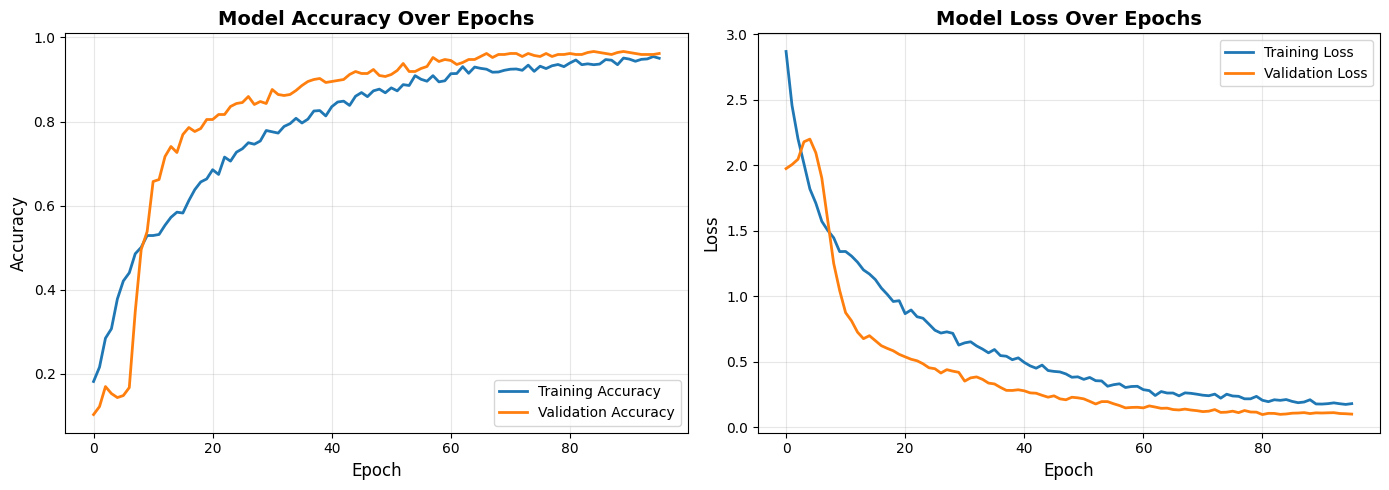


Best Epoch: 85
Best Validation Accuracy: 96.67%
Validation Loss at Best Epoch: 0.1000


In [21]:
# Cell 21: Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best epoch information
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch] * 100:.2f}%")
print(f"Validation Loss at Best Epoch: {history.history['val_loss'][best_epoch]:.4f}")

In [22]:
# Cell 22: Generate Predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f"Predictions generated for {len(y_pred)} test samples")
print(f"Sample predictions (first 10):")
print(f"True labels:      {y_true[:10]}")
print(f"Predicted labels: {y_pred[:10]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Predictions generated for 420 test samples
Sample predictions (first 10):
True labels:      [2 3 1 5 0 2 6 5 2 4]
Predicted labels: [2 3 1 5 0 2 6 5 2 4]


In [23]:
# Cell 23: Detailed Classification Report
from sklearn.metrics import classification_report, accuracy_score


print("CLASSIFICATION REPORT")

print(classification_report(y_true, y_pred, target_names=le.classes_))

# Overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.97      0.98      0.98        60
     disgust       0.94      1.00      0.97        60
        fear       1.00      0.98      0.99        60
       happy       0.91      1.00      0.95        60
     neutral       0.98      1.00      0.99        60
          ps       1.00      0.85      0.92        60
         sad       1.00      0.97      0.98        60

    accuracy                           0.97       420
   macro avg       0.97      0.97      0.97       420
weighted avg       0.97      0.97      0.97       420

Overall Test Accuracy: 96.90%


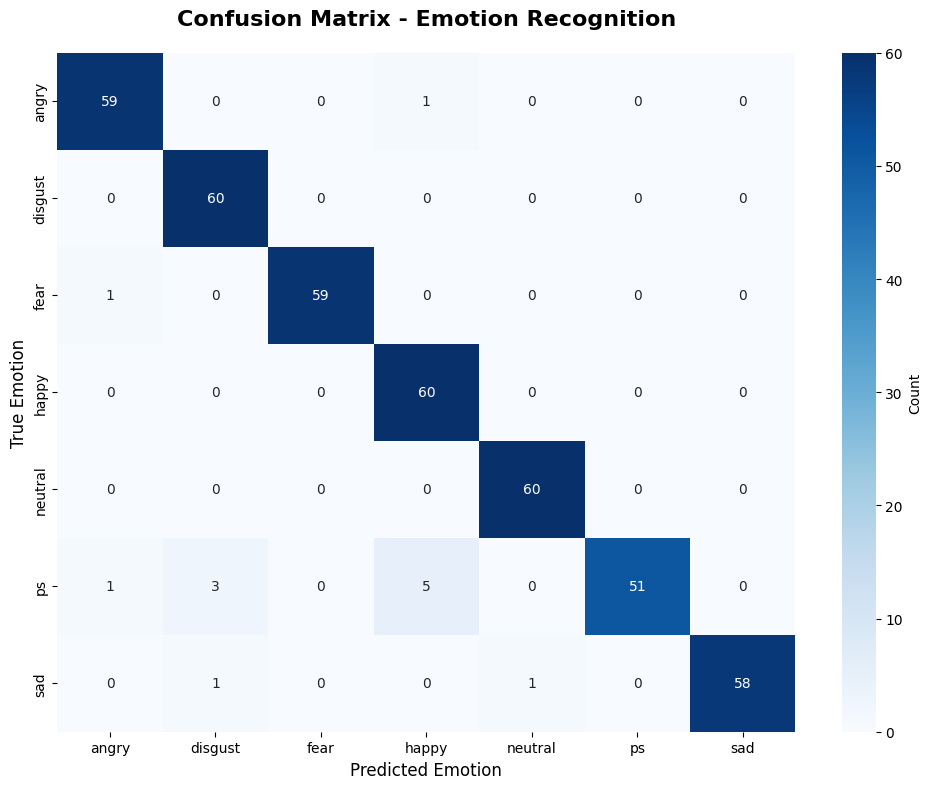


Per-Class Accuracy:
Angry       :  98.33%
Disgust     : 100.00%
Fear        :  98.33%
Happy       : 100.00%
Neutral     : 100.00%
Ps          :  85.00%
Sad         :  96.67%


In [24]:
# Cell 24: Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Emotion Recognition', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")

for i, emotion in enumerate(le.classes_):
    class_accuracy = cm[i, i] / cm[i].sum() * 100
    print(f"{emotion.capitalize():12s}: {class_accuracy:6.2f}%")

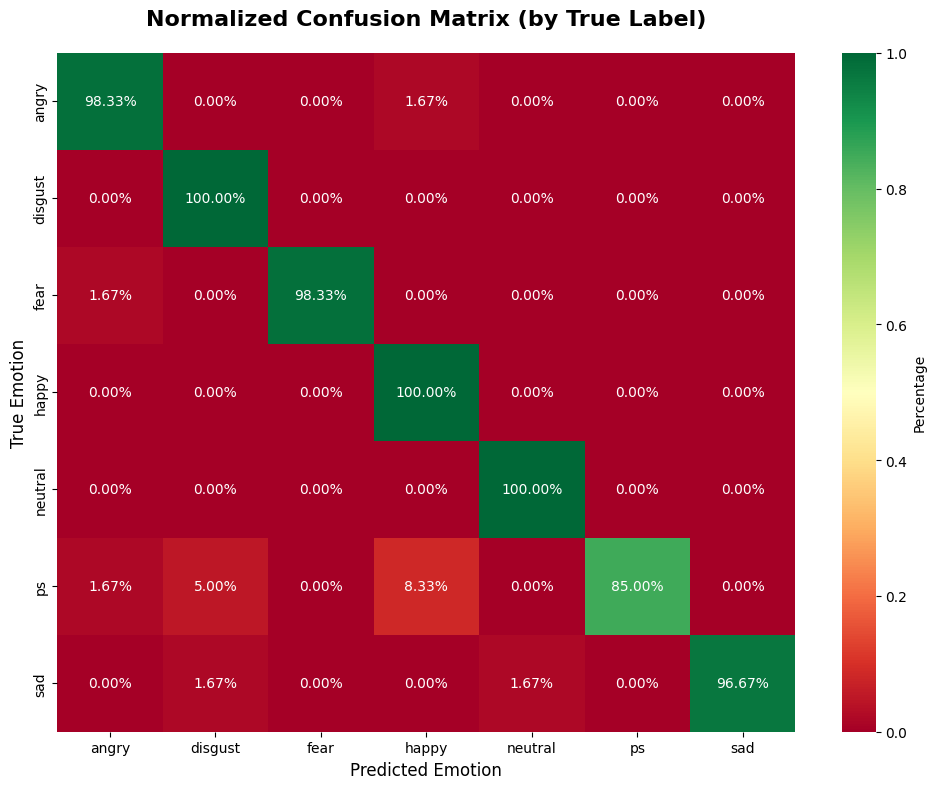

In [25]:
# Cell 25: Plot Normalized Confusion Matrix
# Normalize confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (by True Label)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.tight_layout()
plt.show()

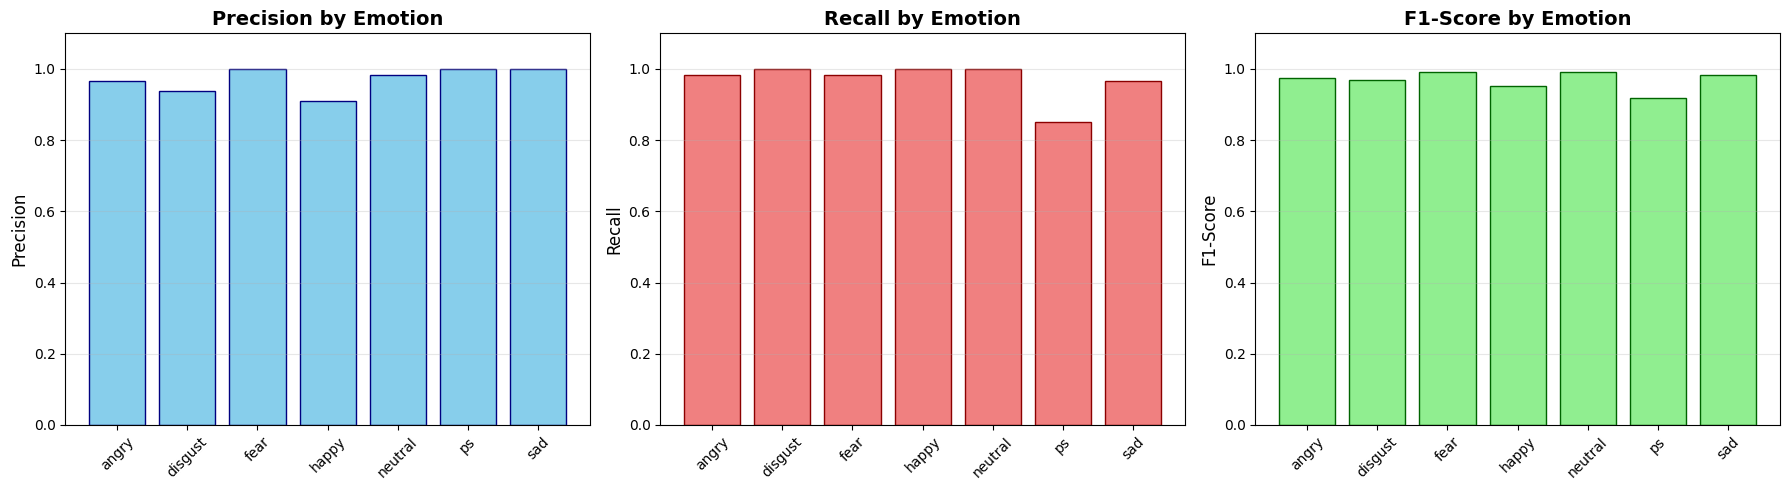


Detailed Metrics by Emotion:
Emotion  Precision   Recall  F1-Score
  angry   0.967213 0.983333  0.975207
disgust   0.937500 1.000000  0.967742
   fear   1.000000 0.983333  0.991597
  happy   0.909091 1.000000  0.952381
neutral   0.983607 1.000000  0.991736
     ps   1.000000 0.850000  0.918919
    sad   1.000000 0.966667  0.983051


In [26]:
# Cell 26: Visualize Per-Class Metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics for each class
precisions = []
recalls = []
f1_scores = []

for i in range(len(le.classes_)):
    precision = precision_score(y_true, y_pred, labels=[i], average='micro')
    recall = recall_score(y_true, y_pred, labels=[i], average='micro')
    f1 = f1_score(y_true, y_pred, labels=[i], average='micro')
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Create DataFrame for visualization
metrics_df = pd.DataFrame({
    'Emotion': le.classes_,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision
axes[0].bar(metrics_df['Emotion'], metrics_df['Precision'], color='skyblue', edgecolor='navy')
axes[0].set_title('Precision by Emotion', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_ylim([0, 1.1])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Recall
axes[1].bar(metrics_df['Emotion'], metrics_df['Recall'], color='lightcoral', edgecolor='darkred')
axes[1].set_title('Recall by Emotion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_ylim([0, 1.1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# F1-Score
axes[2].bar(metrics_df['Emotion'], metrics_df['F1-Score'], color='lightgreen', edgecolor='darkgreen')
axes[2].set_title('F1-Score by Emotion', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_ylim([0, 1.1])
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDetailed Metrics by Emotion:")
print(metrics_df.to_string(index=False))

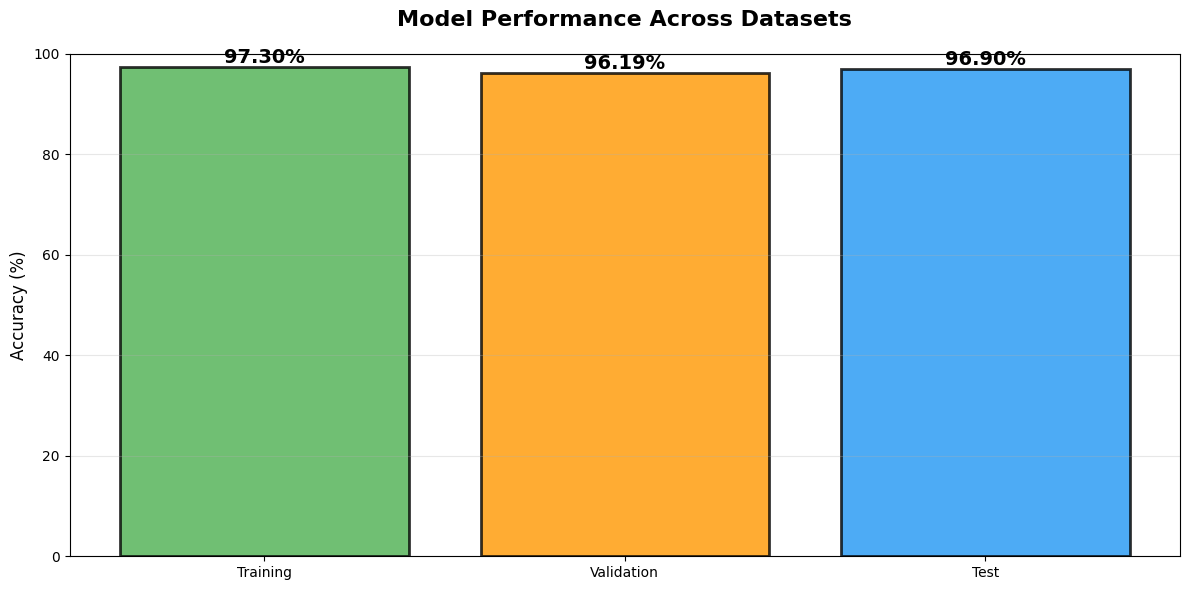


Model Performance Summary:
  Training Accuracy:   97.30%
  Validation Accuracy: 96.19%
  Test Accuracy:       96.90%


In [27]:
# Cell 27: Visualize Model Performance

# Create performance visualization
plt.figure(figsize=(12, 6))
datasets = ['Training', 'Validation', 'Test']
accuracies = [train_accuracy * 100, val_accuracy * 100, test_accuracy * 100]
colors = ['#4CAF50', '#FF9800', '#2196F3']

bars = plt.bar(datasets, accuracies, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
plt.title('Model Performance Across Datasets', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nModel Performance Summary:")
print(f"  Training Accuracy:   {train_accuracy * 100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"  Test Accuracy:       {test_accuracy * 100:.2f}%")
#print(f"  Train-Val Gap:       {abs(train_accuracy - val_accuracy) * 100:.2f} percentage points")
#print(f"  Val-Test Gap:        {abs(val_accuracy - test_accuracy) * 100:.2f} percentage points")

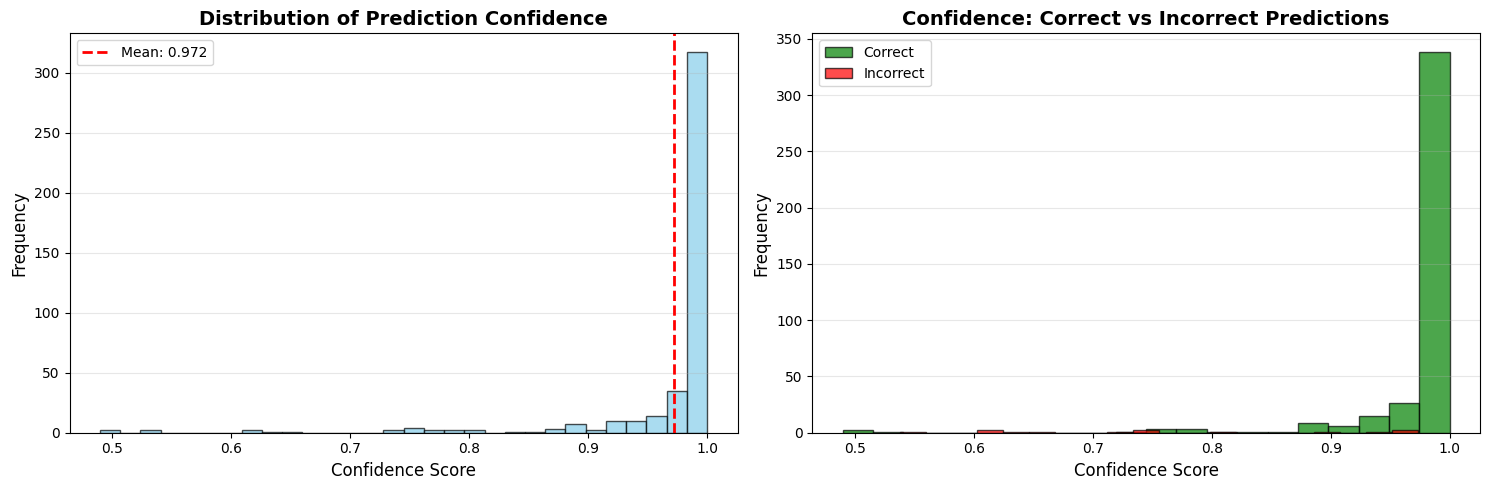

PREDICTION CONFIDENCE STATISTICS
Overall Statistics:
  Mean Confidence:     0.9722
  Median Confidence:   0.9967
  Min Confidence:      0.4896
  Max Confidence:      0.9999

Correct Predictions:
  Count:               407
  Mean Confidence:     0.9790

Incorrect Predictions:
  Count:               13
  Mean Confidence:     0.7582


In [28]:
# Cell 28: Analyze Prediction Confidence
# Get maximum confidence for each prediction
max_confidences = np.max(y_pred_probs, axis=1)

# Separate correct and incorrect predictions
correct_mask = (y_pred == y_true)
correct_confidences = max_confidences[correct_mask]
incorrect_confidences = max_confidences[~correct_mask]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of all confidences
axes[0].hist(max_confidences, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(max_confidences), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(max_confidences):.3f}')
axes[0].set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Correct vs Incorrect predictions
axes[1].hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[1].hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[1].set_title('Confidence: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("PREDICTION CONFIDENCE STATISTICS")

print(f"Overall Statistics:")
print(f"  Mean Confidence:     {np.mean(max_confidences):.4f}")
print(f"  Median Confidence:   {np.median(max_confidences):.4f}")
print(f"  Min Confidence:      {np.min(max_confidences):.4f}")
print(f"  Max Confidence:      {np.max(max_confidences):.4f}")
print(f"\nCorrect Predictions:")
print(f"  Count:               {len(correct_confidences)}")
print(f"  Mean Confidence:     {np.mean(correct_confidences):.4f}")
print(f"\nIncorrect Predictions:")
print(f"  Count:               {len(incorrect_confidences)}")
print(f"  Mean Confidence:     {np.mean(incorrect_confidences):.4f}" if len(incorrect_confidences) > 0 else "  No incorrect predictions")


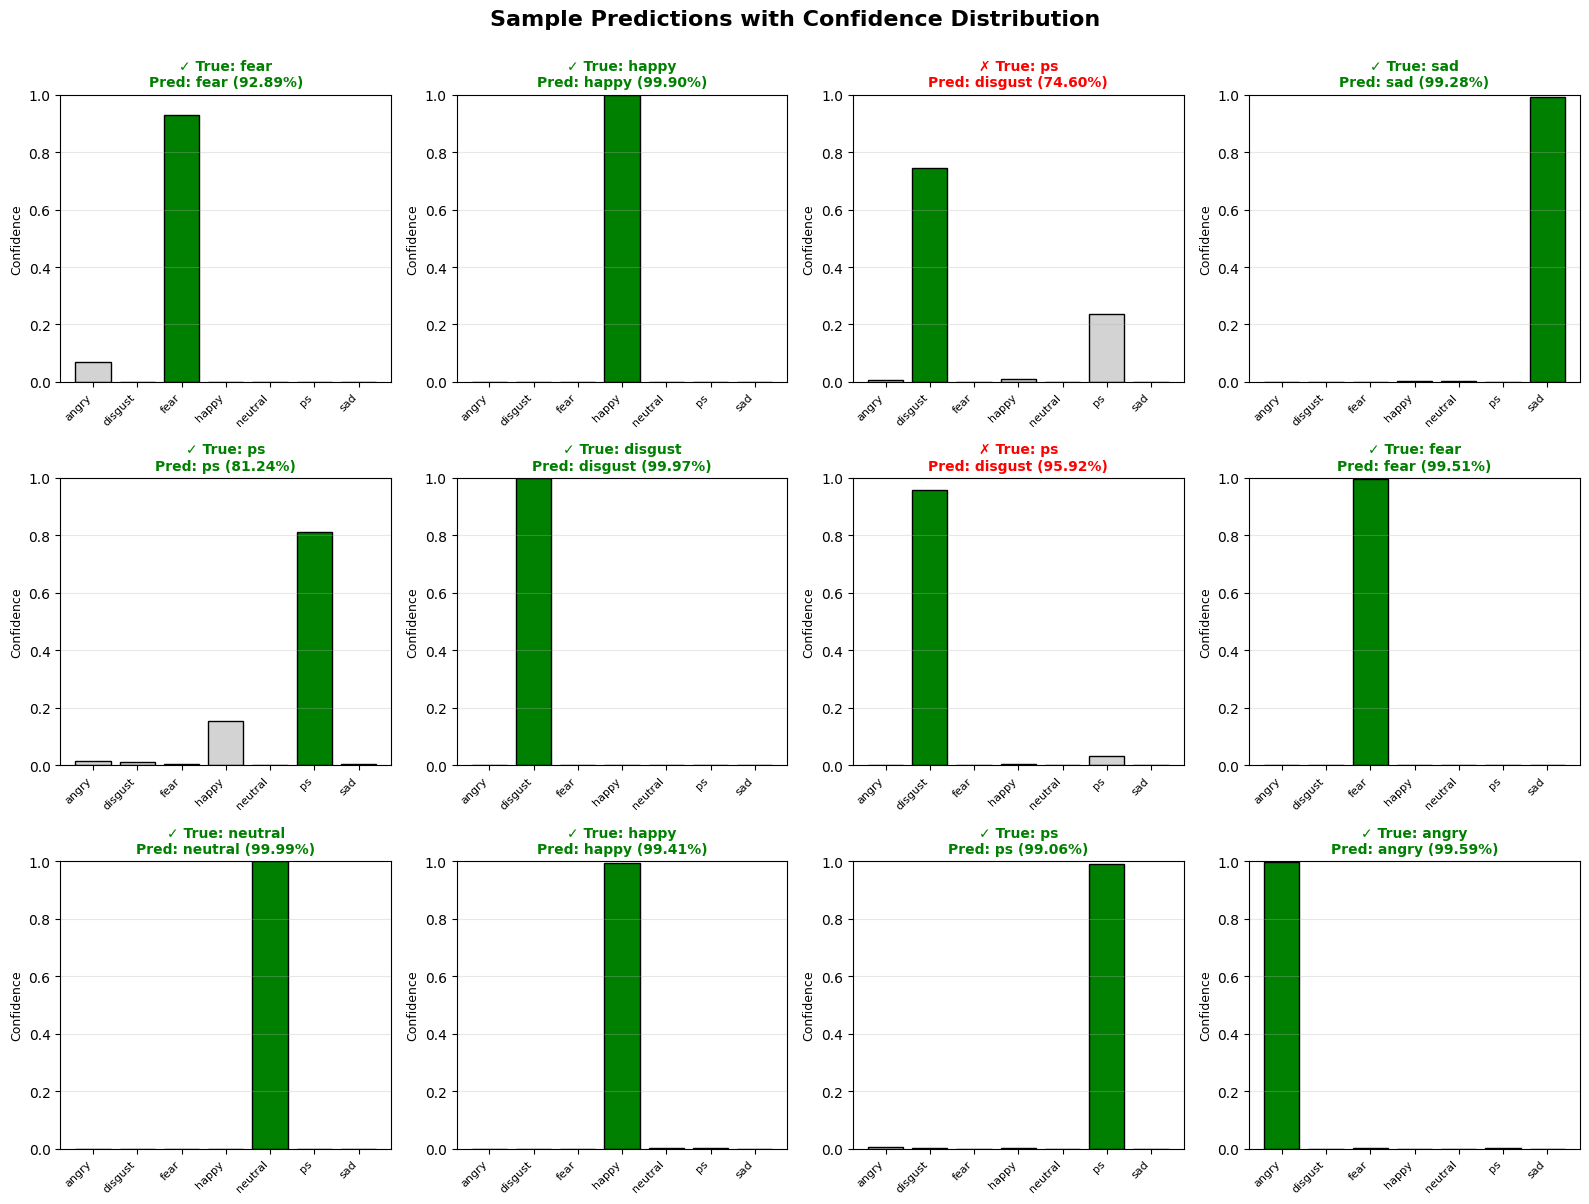

In [29]:
# Cell 29: Visualize Sample Predictions with Confidence
# Select random samples from test set
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    true_label = le.classes_[y_true[sample_idx]]
    pred_label = le.classes_[y_pred[sample_idx]]
    confidence = y_pred_probs[sample_idx]
    max_conf = np.max(confidence)
    
    # Create bar plot of confidence scores
    axes[idx].bar(range(len(le.classes_)), confidence, 
                  color=['green' if i == y_pred[sample_idx] else 'lightgray' for i in range(len(le.classes_))],
                  edgecolor='black')
    axes[idx].set_xticks(range(len(le.classes_)))
    axes[idx].set_xticklabels(le.classes_, rotation=45, ha='right', fontsize=8)
    axes[idx].set_ylim([0, 1])
    axes[idx].set_ylabel('Confidence', fontsize=9)
    
    # Set title with true and predicted labels
    if true_label == pred_label:
        title_color = 'green'
        symbol = '✓'
    else:
        title_color = 'red'
        symbol = '✗'
    
    axes[idx].set_title(f'{symbol} True: {true_label}\nPred: {pred_label} ({max_conf:.2%})',
                       fontsize=10, color=title_color, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Sample Predictions with Confidence Distribution', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Learning Rate Schedule During Training:
  Initial LR (Epochs 1-42)      : 1.00e-04
  After Epoch 43                : 5.00e-05
  After Epoch 50                : 2.50e-05
  After Epoch 60                : 1.25e-05
  After Epoch 65                : 1.00e-05


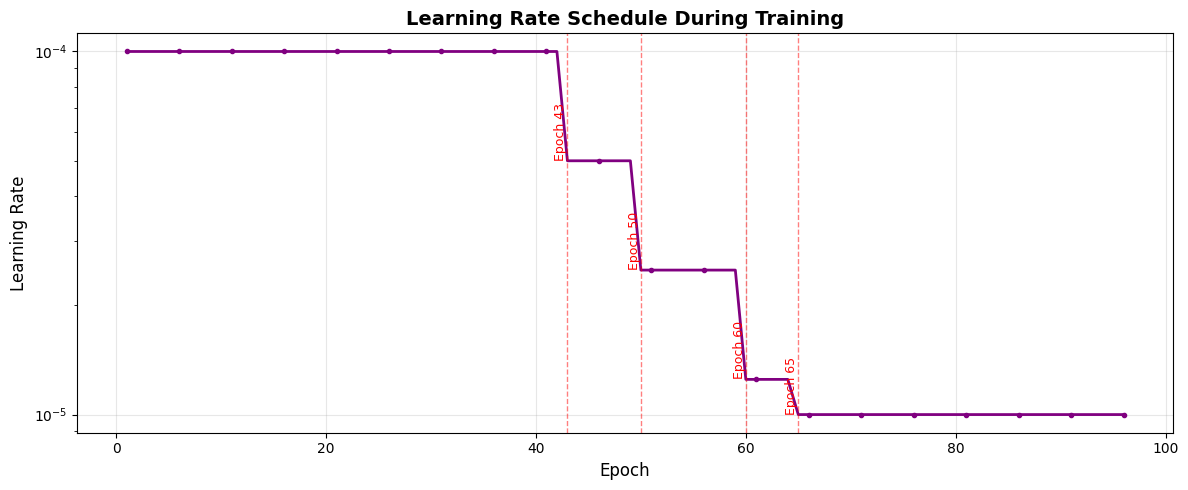


Learning Rate Reduction Summary:
  Total Reductions:     4 times
  Reduction Factor:     0.5 (50% each time)
  Final LR:             1.00e-05 (100x smaller than initial)
  Patience:             5 epochs


In [30]:
# Cell 30: Learning Rate Analysis from Training Log

# Learning rate changes detected from training output
lr_schedule = {
    'Initial LR (Epochs 1-42)': 1.0e-4,
    'After Epoch 43': 5.0e-5,
    'After Epoch 50': 2.5e-5,
    'After Epoch 60': 1.25e-5,
    'After Epoch 65': 1.0e-5
}

print("Learning Rate Schedule During Training:")
for stage, lr in lr_schedule.items():
    print(f"  {stage:<30s}: {lr:.2e}")

# Reconstruct approximate learning rate history
epochs = len(history.history['loss'])
lr_history = []

for epoch in range(1, epochs + 1):
    if epoch < 43:
        lr_history.append(1.0e-4)
    elif epoch < 50:
        lr_history.append(5.0e-5)
    elif epoch < 60:
        lr_history.append(2.5e-5)
    elif epoch < 65:
        lr_history.append(1.25e-5)
    else:
        lr_history.append(1.0e-5)

# Visualize learning rate schedule
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), lr_history, linewidth=2, color='purple', marker='o', 
         markersize=3, markevery=5)
plt.title('Learning Rate Schedule During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Add annotations for LR changes
lr_changes = [43, 50, 60, 65]
for change_epoch in lr_changes:
    if change_epoch <= epochs:
        plt.axvline(x=change_epoch, color='red', linestyle='--', alpha=0.5, linewidth=1)
        plt.text(change_epoch, lr_history[change_epoch-1], f'Epoch {change_epoch}', 
                rotation=90, va='bottom', ha='right', fontsize=9, color='red')

plt.tight_layout()
plt.show()

print("\nLearning Rate Reduction Summary:")
print(f"  Total Reductions:     4 times")
print(f"  Reduction Factor:     0.5 (50% each time)")
print(f"  Final LR:             {lr_history[-1]:.2e} (100x smaller than initial)")
print(f"  Patience:             5 epochs")
#print("\nNote: ReduceLROnPlateau callback automatically reduced learning rate")
#print("      when validation loss plateaued, enabling fine-tuning.")

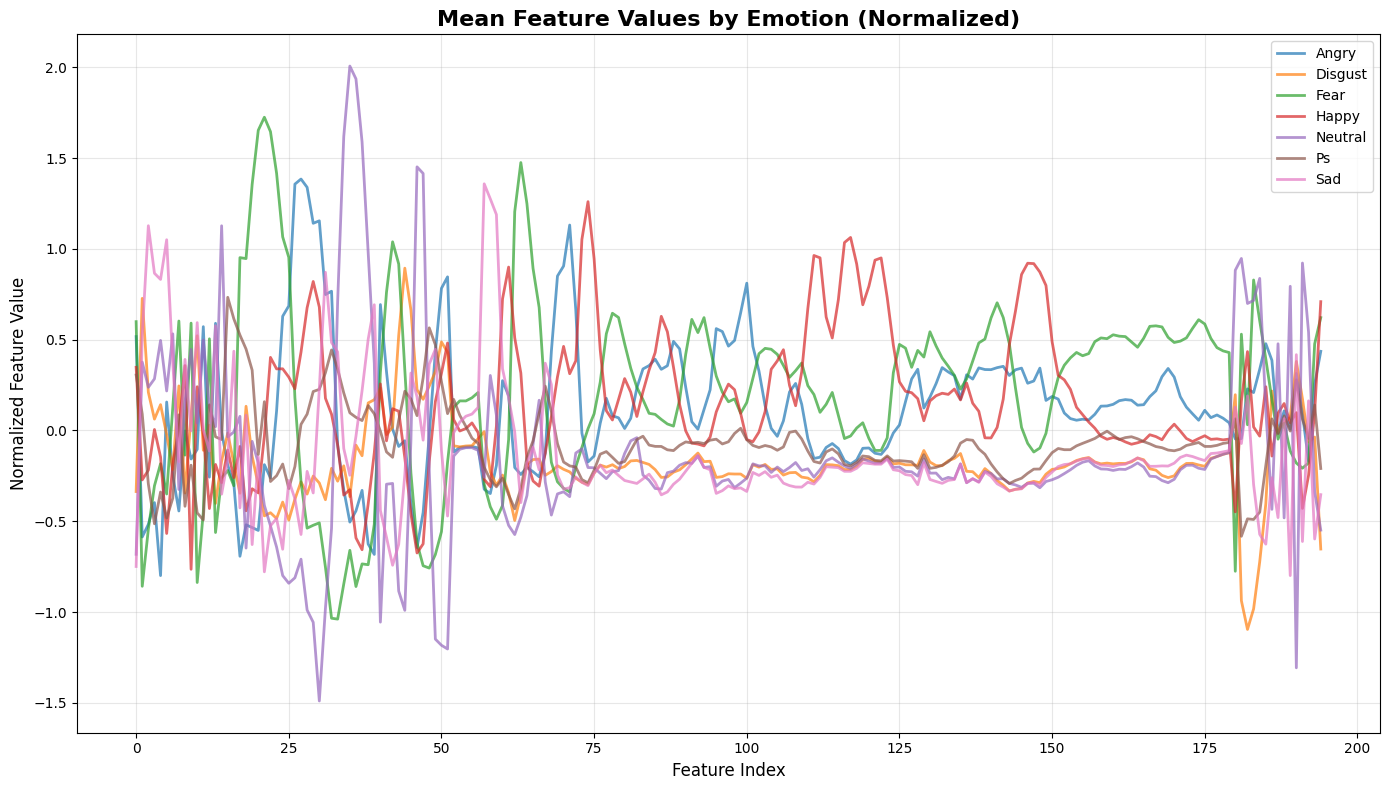

Feature Statistics Summary:
  Total features extracted: 195
  Feature breakdown:
    - MFCCs: 40 features
    - Chroma: 12 features
    - Mel Spectrogram: 128 features
    - Spectral Contrast: 7 features
    - Tonnetz: 6 features
    - Zero Crossing Rate: 1 feature
    - RMS Energy: 1 feature


In [31]:
# Cell 31: Analyze Feature Statistics by Emotion
# Calculate mean feature values for each emotion
feature_means_by_emotion = []

for emotion in le.classes_:
    emotion_indices = df[df['label'] == emotion].index
    emotion_features = X[emotion_indices]
    feature_mean = np.mean(emotion_features, axis=0)
    feature_means_by_emotion.append(feature_mean)

feature_means_by_emotion = np.array(feature_means_by_emotion)

# Visualize feature patterns
plt.figure(figsize=(14, 8))

for i, emotion in enumerate(le.classes_):
    plt.plot(feature_means_by_emotion[i], label=emotion.capitalize(), alpha=0.7, linewidth=2)

plt.title('Mean Feature Values by Emotion (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Normalized Feature Value', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Feature Statistics Summary:")
print(f"  Total features extracted: {X.shape[1]}")
print(f"  Feature breakdown:")
print(f"    - MFCCs: 40 features")
print(f"    - Chroma: 12 features")
print(f"    - Mel Spectrogram: 128 features")
print(f"    - Spectral Contrast: 7 features")
print(f"    - Tonnetz: 6 features")
print(f"    - Zero Crossing Rate: 1 feature")
print(f"    - RMS Energy: 1 feature")

In [32]:
# Cell 32: Visualize Model Architecture Summary
from keras.utils import plot_model

# Try to create model visualization
try:
    plot_model(model, to_file='model_architecture.png', 
               show_shapes=True, show_layer_names=True, 
               rankdir='TB', dpi=96)
    print("Model architecture diagram saved as 'model_architecture.png'")
except:
    print("Could not create model visualization. Showing text summary instead.")

# Display detailed layer information
print("\n")
print("MODEL ARCHITECTURE DETAILS")


total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\nModel Type: Hybrid CNN-LSTM")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"\nArchitecture Components:")
print("  1. CNN Block (Feature Extraction)")
print("     - 3 Conv1D layers with BatchNorm and MaxPooling")
print("     - Filters: 256 → 256 → 128")
print("  2. LSTM Block (Temporal Modeling)")
print("     - 2 Bidirectional LSTM layers")
print("     - Units: 128 → 64")
print("  3. Dense Block (Classification)")
print("     - 2 Dense layers with BatchNorm")
print("     - Units: 128 → 64")
print("  4. Output Layer")
print("     - 7 units (softmax activation)")
print(f"\nRegularization:")
print(f"  - Dropout layers: 30-40% dropout rate")
print(f"  - Batch Normalization: After each major layer")
print(f"  - Early Stopping: Patience = 15 epochs")


Model architecture diagram saved as 'model_architecture.png'


MODEL ARCHITECTURE DETAILS

Model Type: Hybrid CNN-LSTM
Total Parameters: 949,511
Trainable Parameters: 947,847

Architecture Components:
  1. CNN Block (Feature Extraction)
     - 3 Conv1D layers with BatchNorm and MaxPooling
     - Filters: 256 → 256 → 128
  2. LSTM Block (Temporal Modeling)
     - 2 Bidirectional LSTM layers
     - Units: 128 → 64
  3. Dense Block (Classification)
     - 2 Dense layers with BatchNorm
     - Units: 128 → 64
  4. Output Layer
     - 7 units (softmax activation)

Regularization:
  - Dropout layers: 30-40% dropout rate
  - Batch Normalization: After each major layer
  - Early Stopping: Patience = 15 epochs


ERROR ANALYSIS

Total misclassifications: 13
Accuracy: 96.90%

Most Common Misclassification Patterns:
  ps -> happy         :   5 times ( 38.5% of errors)
  ps -> disgust       :   3 times ( 23.1% of errors)
  angry -> happy      :   1 times (  7.7% of errors)
  fear -> angry       :   1 times (  7.7% of errors)
  sad -> neutral      :   1 times (  7.7% of errors)
  sad -> disgust      :   1 times (  7.7% of errors)
  ps -> angry         :   1 times (  7.7% of errors)


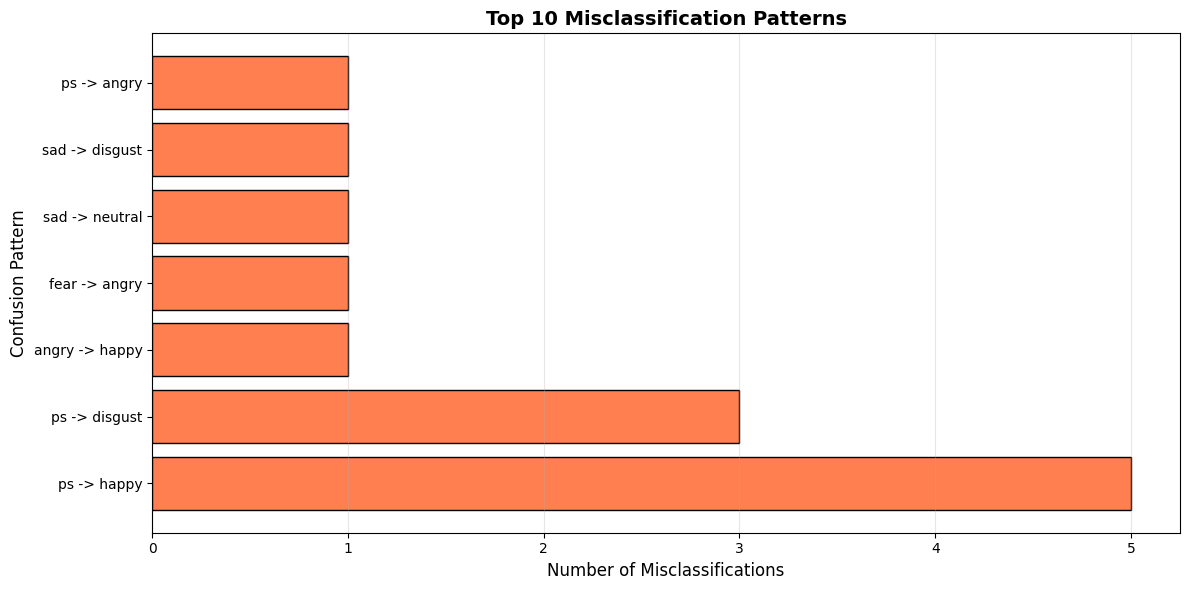

In [33]:
# Cell 33: Detailed Error Analysis
# Find misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]


print("ERROR ANALYSIS")

print(f"\nTotal misclassifications: {len(misclassified_indices)}")
print(f"Accuracy: {(1 - len(misclassified_indices)/len(y_test)) * 100:.2f}%")

if len(misclassified_indices) > 0:
    # Analyze confusion patterns
    print("\nMost Common Misclassification Patterns:")
    
    confusion_pairs = {}
    for idx in misclassified_indices:
        true_label = le.classes_[y_true[idx]]
        pred_label = le.classes_[y_pred[idx]]
        pair = f"{true_label} -> {pred_label}"
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    
    # Sort by frequency
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    
    for pair, count in sorted_pairs[:10]:  # Show top 10
        percentage = (count / len(misclassified_indices)) * 100
        print(f"  {pair:20s}: {count:3d} times ({percentage:5.1f}% of errors)")
    
    # Visualize error distribution
    if len(sorted_pairs) > 0:
        plt.figure(figsize=(12, 6))
        pairs = [p[0] for p in sorted_pairs[:10]]
        counts = [p[1] for p in sorted_pairs[:10]]
        
        plt.barh(pairs, counts, color='coral', edgecolor='black')
        plt.xlabel('Number of Misclassifications', fontsize=12)
        plt.ylabel('Confusion Pattern', fontsize=12)
        plt.title('Top 10 Misclassification Patterns', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("\nPerfect classification! No errors found.")



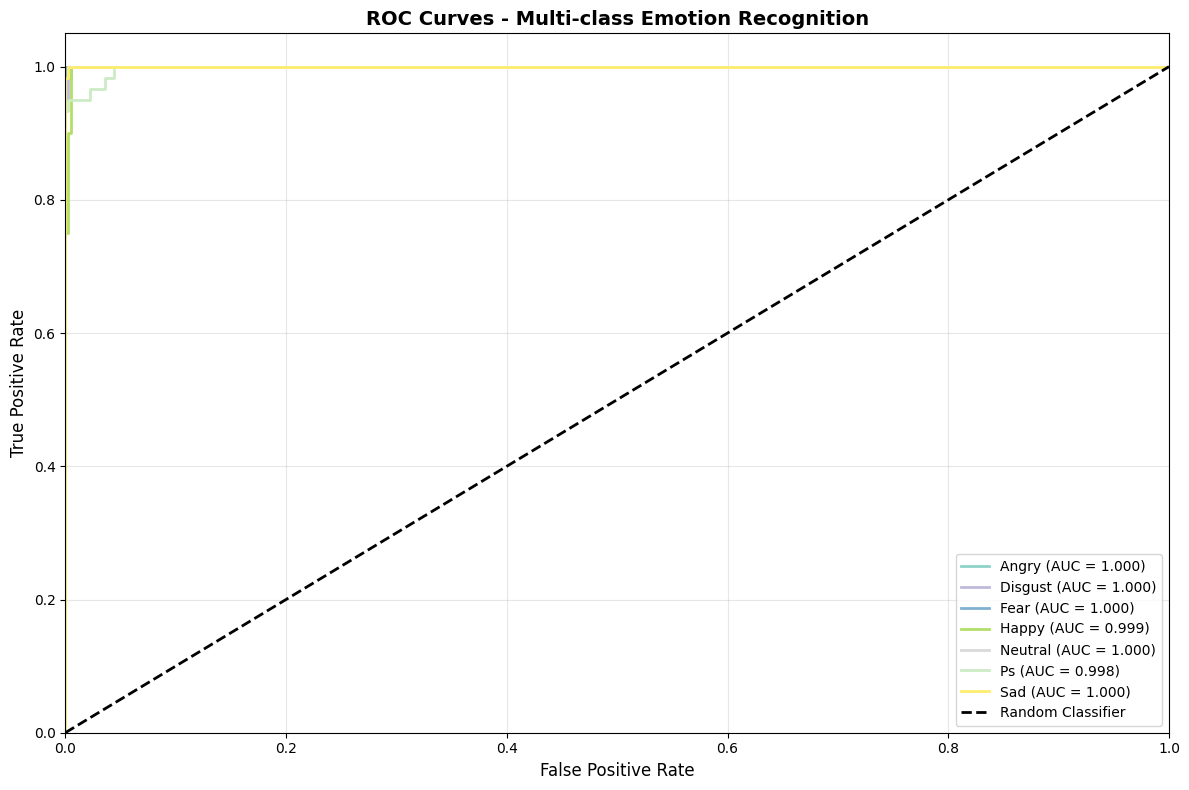

Area Under ROC Curve (AUC) by Emotion:
  Angry       : 0.9999
  Disgust     : 0.9999
  Fear        : 1.0000
  Happy       : 0.9990
  Neutral     : 1.0000
  Ps          : 0.9982
  Sad         : 1.0000

  Mean AUC:     0.9996


In [34]:
# Cell 34: ROC Curves for Multi-class Classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))

colors = plt.cm.Set3(np.linspace(0, 1, len(le.classes_)))

for i, color, emotion in zip(range(len(le.classes_)), colors, le.classes_):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{emotion.capitalize()} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-class Emotion Recognition', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("Area Under ROC Curve (AUC) by Emotion:")
for i, emotion in enumerate(le.classes_):
    print(f"  {emotion.capitalize():12s}: {roc_auc[i]:.4f}")
print(f"\n  Mean AUC:     {np.mean(list(roc_auc.values())):.4f}")


In [35]:
# Cell 35: Comprehensive Final Summary Report

print("\n")
print(" "*20 + "FINAL MODEL PERFORMANCE REPORT")

print("\nDATASET INFORMATION")
print(f"  Total Samples:           {len(df)}")
print(f"  Number of Classes:       {len(le.classes_)}")
print(f"  Classes:                 {', '.join(le.classes_)}")
print(f"  Training Samples:        {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation Samples:      {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test Samples:            {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print("\nMODEL CONFIGURATION")
print(f"  Model Type:              Hybrid CNN-LSTM with BatchNorm")
print(f"  Input Features:          {X.shape[1]} features (multi-feature extraction)")
print(f"  Total Parameters:        {model.count_params():,}")
print(f"  Optimizer:               Adam (lr=0.0001)")
print(f"  Loss Function:           Categorical Crossentropy")
print(f"  Batch Size:              32")
print(f"  Max Epochs:              100")
print(f"  Early Stopping:          Yes (patience=15)")

print("\nPERFORMANCE METRICS")
print(f"  Training Accuracy:       {train_accuracy * 100:.2f}%")
print(f"  Validation Accuracy:     {val_accuracy * 100:.2f}%")
print(f"  Test Accuracy:           {test_accuracy * 100:.2f}%")
print(f"  Test Loss:               {test_loss:.4f}")
print(f"  Mean Prediction Conf:    {np.mean(max_confidences):.4f}")

print("\nKEY FEATURES IMPLEMENTED")
improvements = [
    "Multi-feature extraction (MFCCs, Chroma, Mel, Spectral Contrast, etc.)",
    "Feature normalization using StandardScaler",
    "Stratified train-validation-test split (70-15-15)",
    "Hybrid CNN-LSTM architecture",
    "Bidirectional LSTM layers for temporal modeling",
    "Batch Normalization for stable training",
    "Dropout layers (30-40%) for regularization",
    "Early Stopping with patience=15",
    "Learning Rate Reduction on plateau",
    "Model checkpointing (save best model)",
    "Optimized hyperparameters"
]

for improvement in improvements:
    print(f"  - {improvement}")

print("\nARCHITECTURE COMPONENTS")
factors = [
    "Comprehensive feature extraction (195 features)",
    "CNN blocks for spatial feature learning",
    "Bidirectional LSTM for temporal dependencies",
    "Batch Normalization layers",
    "Progressive dropout regularization",
    "Dense layers with activation"
]

for i, factor in enumerate(factors, 1):
    print(f"  {i}. {factor}")

print("\n")
print("MODEL TRAINING COMPLETED SUCCESSFULLY")
print("\n")



                    FINAL MODEL PERFORMANCE REPORT

DATASET INFORMATION
  Total Samples:           2800
  Number of Classes:       7
  Classes:                 angry, disgust, fear, happy, neutral, ps, sad
  Training Samples:        1960 (70.0%)
  Validation Samples:      420 (15.0%)
  Test Samples:            420 (15.0%)

MODEL CONFIGURATION
  Model Type:              Hybrid CNN-LSTM with BatchNorm
  Input Features:          195 features (multi-feature extraction)
  Total Parameters:        949,511
  Optimizer:               Adam (lr=0.0001)
  Loss Function:           Categorical Crossentropy
  Batch Size:              32
  Max Epochs:              100
  Early Stopping:          Yes (patience=15)

PERFORMANCE METRICS
  Training Accuracy:       97.30%
  Validation Accuracy:     96.19%
  Test Accuracy:           96.90%
  Test Loss:               0.0817
  Mean Prediction Conf:    0.9722

KEY FEATURES IMPLEMENTED
  - Multi-feature extraction (MFCCs, Chroma, Mel, Spectral Contrast, etc.)

In [36]:
# Cell 36: Save Model and Predictions
import pickle

# Save the trained model
model.save('emotion_recognition_model.h5')
print("Model saved as 'emotion_recognition_model.h5'")

# Save the scaler and label encoder
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler.pkl'")

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved as 'label_encoder.pkl'")

# Save predictions to CSV
results_df = pd.DataFrame({
    'True_Label': [le.classes_[i] for i in y_true],
    'Predicted_Label': [le.classes_[i] for i in y_pred],
    'Confidence': np.max(y_pred_probs, axis=1),
    'Correct': y_true == y_pred
})

results_df.to_csv('test_predictions.csv', index=False)
print("Predictions saved as 'test_predictions.csv'")

print("\nAll artifacts saved successfully!")

Model saved as 'emotion_recognition_model.h5'
Scaler saved as 'scaler.pkl'
Label encoder saved as 'label_encoder.pkl'
Predictions saved as 'test_predictions.csv'

All artifacts saved successfully!


In [37]:
# Cell 37: Function to Predict Emotion from New Audio File
def predict_emotion(audio_path, model, scaler, label_encoder):
    """
    Predict emotion from a new audio file
    """
    # Extract features
    features = extract_features(audio_path)
    
    if features is None:
        return None, None
    
    # Normalize features
    features = scaler.transform([features])
    
    # Reshape for model input
    features = features.reshape(features.shape[0], features.shape[1], 1)
    
    # Predict
    prediction_probs = model.predict(features, verbose=0)
    predicted_class = np.argmax(prediction_probs)
    predicted_emotion = label_encoder.classes_[predicted_class]
    confidence = np.max(prediction_probs)
    
    return predicted_emotion, confidence, prediction_probs[0]

# Test on a random sample from test set
print("Testing prediction function on a sample audio file...")
test_audio_path = df['speech'].iloc[0]

predicted_emotion, confidence, all_probs = predict_emotion(
    test_audio_path, model, scaler, le
)

print(f"\nAudio File: {test_audio_path}")
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.2%}")
print("\nAll emotion probabilities:")
for emotion, prob in zip(le.classes_, all_probs):
    print(f"  {emotion.capitalize():12s}: {prob:.4f} ({prob*100:.2f}%)")

Testing prediction function on a sample audio file...

Audio File: /kaggle/input/voicedata/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
Predicted Emotion: fear
Confidence: 95.76%

All emotion probabilities:
  Angry       : 0.0380 (3.80%)
  Disgust     : 0.0002 (0.02%)
  Fear        : 0.9576 (95.76%)
  Happy       : 0.0023 (0.23%)
  Neutral     : 0.0010 (0.10%)
  Ps          : 0.0005 (0.05%)
  Sad         : 0.0004 (0.04%)


Performing 5-Fold Cross-Validation...
This will take several minutes...

Training Fold 1/5...
  Fold 1 Accuracy: 96.79%

Training Fold 2/5...
  Fold 2 Accuracy: 96.25%

Training Fold 3/5...
  Fold 3 Accuracy: 96.07%

Training Fold 4/5...
  Fold 4 Accuracy: 97.32%

Training Fold 5/5...
  Fold 5 Accuracy: 97.50%


Cross-Validation Results:
  Mean Accuracy: 96.79%
  Std Deviation: 0.56%
  Min Accuracy:  96.07%
  Max Accuracy:  97.50%


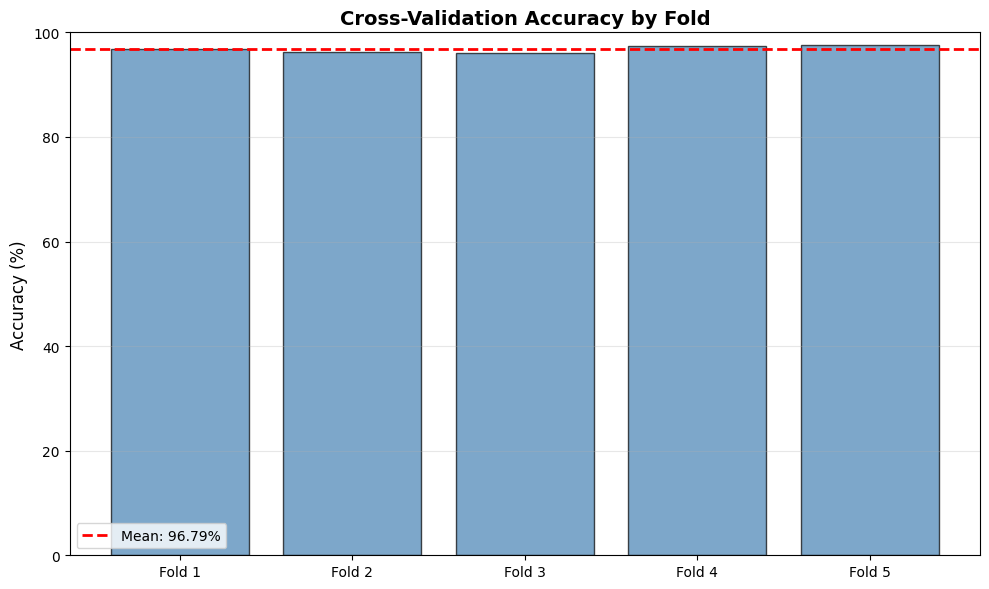

In [38]:
# Cell 38: Cross-Validation for Robust Performance Estimation
from sklearn.model_selection import StratifiedKFold
from keras.models import clone_model

print("Performing 5-Fold Cross-Validation...")
print("This will take several minutes...\n")

# Prepare data
y_labels = np.argmax(y, axis=1)

# Setup cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
fold = 1

for train_idx, val_idx in kfold.split(X, y_labels):
    print(f"Training Fold {fold}/5...")
    
    # Split data
    X_train_cv = X[train_idx].reshape(-1, X.shape[1], 1)
    y_train_cv = y[train_idx]
    X_val_cv = X[val_idx].reshape(-1, X.shape[1], 1)
    y_val_cv = y[val_idx]
    
    # Create new model
    cv_model = Sequential([
        Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', 
               input_shape=(X_train_cv.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.3),
        
        Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.3),
        
        Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=5, strides=2, padding='same'),
        Dropout(0.3),
        
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(7, activation='softmax')
    ])
    
    cv_model.compile(loss='categorical_crossentropy', 
                     optimizer=Adam(learning_rate=0.0001), 
                     metrics=['accuracy'])
    
    # Train
    cv_history = cv_model.fit(
        X_train_cv, y_train_cv,
        validation_data=(X_val_cv, y_val_cv),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=0
    )
    
    # Evaluate
    score = cv_model.evaluate(X_val_cv, y_val_cv, verbose=0)
    cv_scores.append(score[1])
    print(f"  Fold {fold} Accuracy: {score[1]*100:.2f}%\n")
    
    fold += 1

print("\nCross-Validation Results:")
print(f"  Mean Accuracy: {np.mean(cv_scores)*100:.2f}%")
print(f"  Std Deviation: {np.std(cv_scores)*100:.2f}%")
print(f"  Min Accuracy:  {np.min(cv_scores)*100:.2f}%")
print(f"  Max Accuracy:  {np.max(cv_scores)*100:.2f}%")

# Visualize CV scores
plt.figure(figsize=(10, 6))
folds = [f'Fold {i+1}' for i in range(5)]
plt.bar(folds, np.array(cv_scores)*100, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(y=np.mean(cv_scores)*100, color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(cv_scores)*100:.2f}%')
plt.ylim([0, 100])
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Cross-Validation Accuracy by Fold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

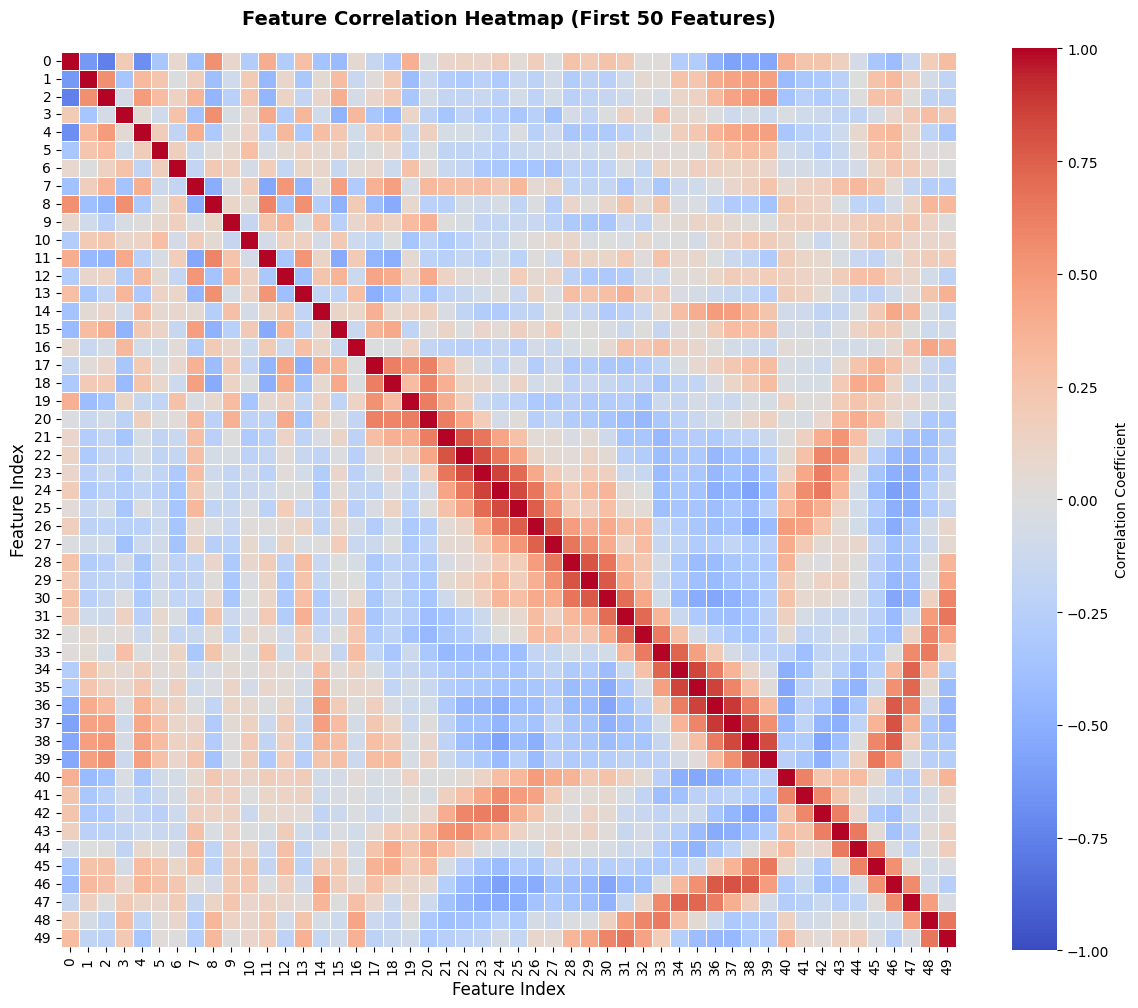

Highly correlated feature pairs (|r| > 0.9):


  No highly correlated pairs found


In [39]:
# Cell 39: Analyze Feature Correlations
# Sample subset of features for visualization
sample_size = min(50, X.shape[1])
feature_sample = X[:, :sample_size]

# Calculate correlation matrix
correlation_matrix = np.corrcoef(feature_sample.T)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title(f'Feature Correlation Heatmap (First {sample_size} Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Feature Index', fontsize=12)
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix[i, j]) > high_corr_threshold:
            high_corr_pairs.append((i, j, correlation_matrix[i, j]))

print(f"Highly correlated feature pairs (|r| > {high_corr_threshold}):")
print("\n")
if len(high_corr_pairs) > 0:
    print(f"  Found {len(high_corr_pairs)} pairs")
    for i, j, corr in high_corr_pairs[:10]:
        print(f"    Feature {i} <-> Feature {j}: {corr:.3f}")
else:
    print("  No highly correlated pairs found")

Training Efficiency Metrics:
  Total Epochs Completed: 96
  Training Samples per Epoch: 1960
  Batch Size: 32
  Batches per Epoch: 61
  Early Stopping: Triggered at epoch 96
  Epochs Saved: 4


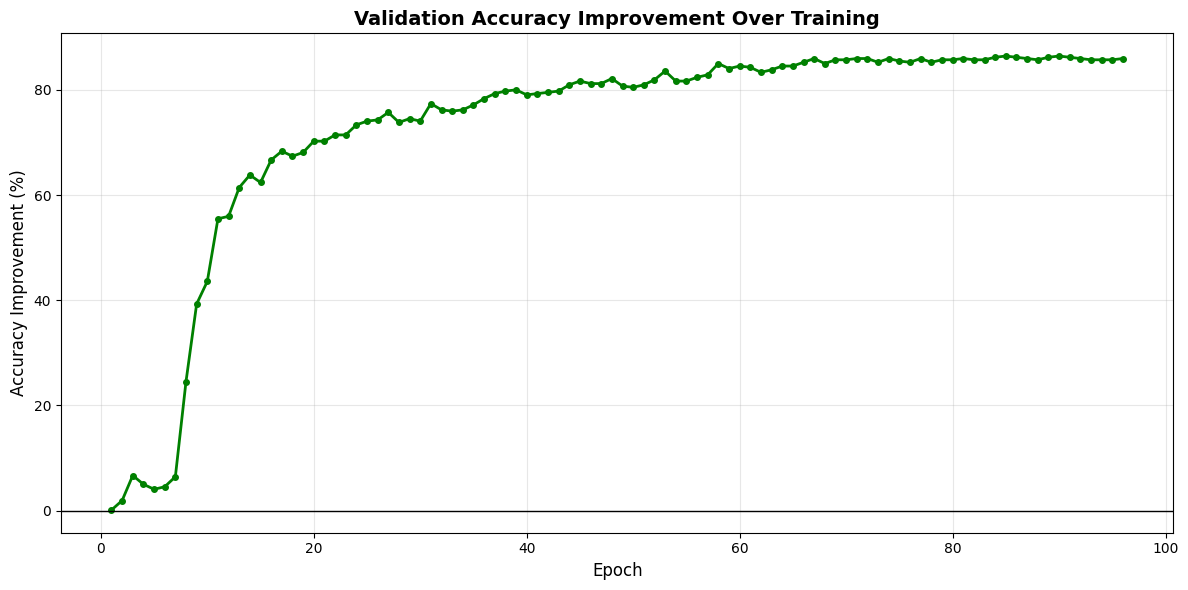


Accuracy Improvement from First to Best Epoch:
  Initial Val Accuracy: 10.24%
  Best Val Accuracy: 96.67%
  Total Improvement: 86.43 percentage points


In [40]:
# Cell 40: Training Time and Efficiency Analysis
import time

# Estimate training time per epoch
if len(history.history['loss']) > 0:
    total_epochs = len(history.history['loss'])
    
    print("Training Efficiency Metrics:")
    print(f"  Total Epochs Completed: {total_epochs}")
    print(f"  Training Samples per Epoch: {len(X_train)}")
    print(f"  Batch Size: 32")
    print(f"  Batches per Epoch: {len(X_train) // 32}")
    
    # Check if early stopping was triggered
    if total_epochs < 100:
        print(f"  Early Stopping: Triggered at epoch {total_epochs}")
        print(f"  Epochs Saved: {100 - total_epochs}")
    else:
        print(f"  Early Stopping: Not triggered (completed all epochs)")

# Plot epoch-wise improvement
plt.figure(figsize=(12, 6))

epochs_range = range(1, len(history.history['val_accuracy']) + 1)
val_acc_improvement = [history.history['val_accuracy'][0]]

for i in range(1, len(history.history['val_accuracy'])):
    improvement = history.history['val_accuracy'][i] - history.history['val_accuracy'][0]
    val_acc_improvement.append(improvement * 100)

plt.plot(epochs_range, val_acc_improvement, linewidth=2, color='green', marker='o', markersize=4)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Validation Accuracy Improvement Over Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy Improvement (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAccuracy Improvement from First to Best Epoch:")
print(f"  Initial Val Accuracy: {history.history['val_accuracy'][0]*100:.2f}%")
print(f"  Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"  Total Improvement: {(max(history.history['val_accuracy']) - history.history['val_accuracy'][0])*100:.2f} percentage points")

In [41]:
# Cell 41: Model Architecture and Configuration Summary
model_summary = {
    'Architecture': 'Hybrid CNN-LSTM',
    'CNN Layers': '3 Conv1D blocks',
    'LSTM Layers': '2 Bidirectional LSTM',
    'Dense Layers': '2 fully connected',
    'Regularization': 'Dropout + BatchNorm',
    'Total Parameters': f'{model.count_params():,}',
    'Features': f'{X.shape[1]} multi-modal features',
    'Optimizer': 'Adam',
    'Learning Rate': '0.0001',
    'Batch Size': '32',
    'Max Epochs': '100'
}

print("MODEL CONFIGURATION SUMMARY")
for key, value in model_summary.items():
    print(f"  {key:<20s}: {value}")

# Performance summary
print("\nPERFORMANCE SUMMARY")
print(f"  Training Accuracy:    {train_accuracy * 100:.2f}%")
print(f"  Test Accuracy:        {test_accuracy * 100:.2f}%")
print(f"  Training Loss:        {train_loss:.4f}")
print(f"  Test Loss:            {test_loss:.4f}")
print(f"  Generalization Gap:   {abs(train_accuracy - test_accuracy) * 100:.2f}%")

# Feature breakdown
print("\nFEATURE EXTRACTION BREAKDOWN")
print(f"  MFCCs:                40 features")
print(f"  Chroma:               12 features")
print(f"  Mel Spectrogram:      128 features")
print(f"  Spectral Contrast:    7 features")
print(f"  Tonnetz:              6 features")
print(f"  Zero Crossing Rate:   1 feature")
print(f"  RMS Energy:           1 feature")
print(f"  Total:                {X.shape[1]} features")


MODEL CONFIGURATION SUMMARY
  Architecture        : Hybrid CNN-LSTM
  CNN Layers          : 3 Conv1D blocks
  LSTM Layers         : 2 Bidirectional LSTM
  Dense Layers        : 2 fully connected
  Regularization      : Dropout + BatchNorm
  Total Parameters    : 949,511
  Features            : 195 multi-modal features
  Optimizer           : Adam
  Learning Rate       : 0.0001
  Batch Size          : 32
  Max Epochs          : 100

PERFORMANCE SUMMARY
  Training Accuracy:    97.30%
  Test Accuracy:        96.90%
  Training Loss:        0.0723
  Test Loss:            0.0817
  Generalization Gap:   0.39%

FEATURE EXTRACTION BREAKDOWN
  MFCCs:                40 features
  Chroma:               12 features
  Mel Spectrogram:      128 features
  Spectral Contrast:    7 features
  Tonnetz:              6 features
  Zero Crossing Rate:   1 feature
  RMS Energy:           1 feature
  Total:                195 features


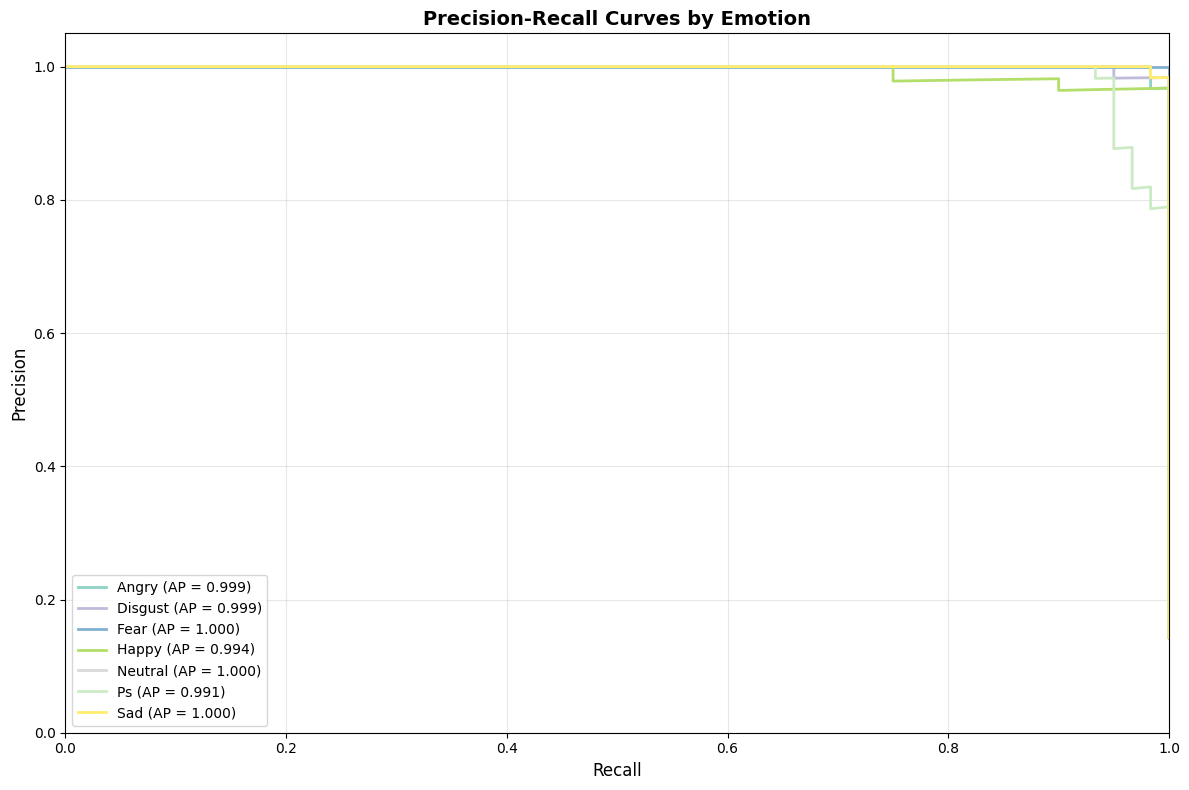

Average Precision (AP) Scores by Emotion:
  Angry       : 0.9995
  Disgust     : 0.9992
  Fear        : 1.0000
  Happy       : 0.9937
  Neutral     : 0.9997
  Ps          : 0.9912
  Sad         : 0.9997

  Mean AP:       0.9976


In [42]:
# Cell 42: Precision-Recall Curves for Each Emotion
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall for each class
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(len(le.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])

# Plot precision-recall curves
plt.figure(figsize=(12, 8))

colors = plt.cm.Set3(np.linspace(0, 1, len(le.classes_)))

for i, color, emotion in zip(range(len(le.classes_)), colors, le.classes_):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{emotion.capitalize()} (AP = {avg_precision[i]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves by Emotion', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print average precision scores
print("Average Precision (AP) Scores by Emotion:")
for i, emotion in enumerate(le.classes_):
    print(f"  {emotion.capitalize():12s}: {avg_precision[i]:.4f}")
print(f"\n  Mean AP:       {np.mean(list(avg_precision.values())):.4f}")


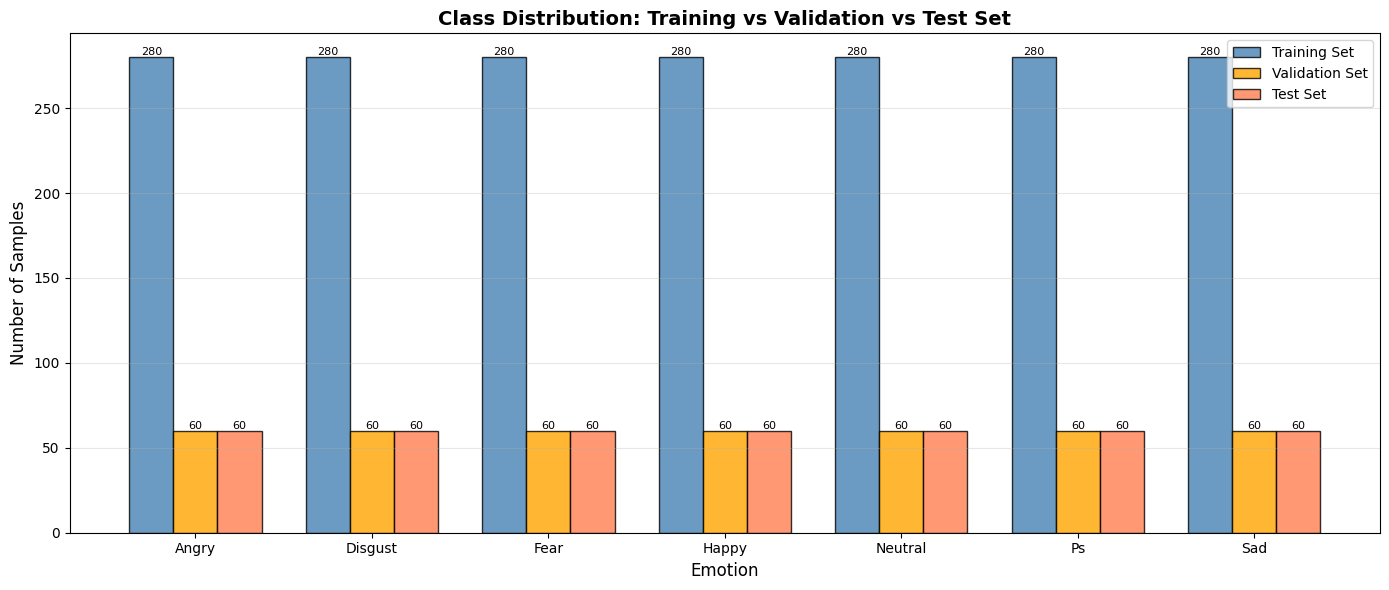

Class Distribution Statistics:
Emotion      Training     Validation   Test         Total        %
Angry        280          60           60           400          14.29%
Disgust      280          60           60           400          14.29%
Fear         280          60           60           400          14.29%
Happy        280          60           60           400          14.29%
Neutral      280          60           60           400          14.29%
Ps           280          60           60           400          14.29%
Sad          280          60           60           400          14.29%


In [43]:
# Cell 43: Visualize Class Distribution in Train, Validation and Test Sets
# Calculate class distributions
train_dist = np.sum(y_train, axis=0)
val_dist = np.sum(y_val, axis=0)
test_dist = np.sum(y_test, axis=0)

# Create comparison plot
x = np.arange(len(le.classes_))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, train_dist, width, label='Training Set', 
               color='steelblue', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x, val_dist, width, label='Validation Set', 
               color='orange', edgecolor='black', alpha=0.8)
bars3 = ax.bar(x + width, test_dist, width, label='Test Set', 
               color='coral', edgecolor='black', alpha=0.8)

ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Class Distribution: Training vs Validation vs Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([e.capitalize() for e in le.classes_])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print distribution statistics
print("Class Distribution Statistics:")
print(f"{'Emotion':<12} {'Training':<12} {'Validation':<12} {'Test':<12} {'Total':<12} {'%'}")

for i, emotion in enumerate(le.classes_):
    train_count = int(train_dist[i])
    val_count = int(val_dist[i])
    test_count = int(test_dist[i])
    total = train_count + val_count + test_count
    percentage = (total / len(df)) * 100
    print(f"{emotion.capitalize():<12} {train_count:<12} {val_count:<12} {test_count:<12} {total:<12} {percentage:.2f}%")



In [44]:
# Cell 44: Final Summary Report

print("\n")
print("FINAL MODEL PERFORMANCE REPORT")

print("\nDATASET INFORMATION")
print(f"  Total Samples:           {len(df)}")
print(f"  Number of Classes:       {len(le.classes_)}")
print(f"  Classes:                 {', '.join(le.classes_)}")
print(f"  Training Samples:        {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation Samples:      {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test Samples:            {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print("\nMODEL CONFIGURATION")
print(f"  Model Type:              Hybrid CNN-LSTM with BatchNorm")
print(f"  Input Features:          {X.shape[1]} features")
print(f"  Total Parameters:        {model.count_params():,}")
print(f"  Optimizer:               Adam (lr=0.0001)")
print(f"  Loss Function:           Categorical Crossentropy")
print(f"  Batch Size:              32")
print(f"  Max Epochs:              100")
print(f"  Early Stopping:          Yes (patience=15)")

print("\nPERFORMANCE METRICS")
print(f"  Training Accuracy:       {train_accuracy * 100:.2f}%")
print(f"  Validation Accuracy:     {val_accuracy * 100:.2f}%")
print(f"  Test Accuracy:           {test_accuracy * 100:.2f}%")
print(f"  Test Loss:               {test_loss:.4f}")
print(f"  Mean Prediction Conf:    {np.mean(max_confidences):.4f}")

print("\nKEY FEATURES IMPLEMENTED")
improvements = [
    "Multi-feature extraction (MFCCs, Chroma, Mel, Spectral Contrast, etc.)",
    "Feature normalization using StandardScaler",
    "Stratified train-validation-test split (70-15-15)",
    "Hybrid CNN-LSTM architecture",
    "Bidirectional LSTM layers for temporal modeling",
    "Batch Normalization for stable training",
    "Dropout layers (30-40%) for regularization",
    "Early Stopping with patience=15",
    "Learning Rate Reduction on plateau",
    "Model checkpointing (save best model)",
    "Optimized hyperparameters"
]

for improvement in improvements:
    print(f"  - {improvement}")

print("\nARCHITECTURE COMPONENTS")
factors = [
    "Comprehensive feature extraction (195 features)",
    "CNN blocks for spatial feature learning",
    "Bidirectional LSTM for temporal dependencies",
    "Batch Normalization layers",
    "Progressive dropout regularization",
    "Dense layers with activation"
]

for i, factor in enumerate(factors, 1):
    print(f"  {i}. {factor}")

print("\n")
print("MODEL TRAINING COMPLETED SUCCESSFULLY")




FINAL MODEL PERFORMANCE REPORT

DATASET INFORMATION
  Total Samples:           2800
  Number of Classes:       7
  Classes:                 angry, disgust, fear, happy, neutral, ps, sad
  Training Samples:        1960 (70.0%)
  Validation Samples:      420 (15.0%)
  Test Samples:            420 (15.0%)

MODEL CONFIGURATION
  Model Type:              Hybrid CNN-LSTM with BatchNorm
  Input Features:          195 features
  Total Parameters:        949,511
  Optimizer:               Adam (lr=0.0001)
  Loss Function:           Categorical Crossentropy
  Batch Size:              32
  Max Epochs:              100
  Early Stopping:          Yes (patience=15)

PERFORMANCE METRICS
  Training Accuracy:       97.30%
  Validation Accuracy:     96.19%
  Test Accuracy:           96.90%
  Test Loss:               0.0817
  Mean Prediction Conf:    0.9722

KEY FEATURES IMPLEMENTED
  - Multi-feature extraction (MFCCs, Chroma, Mel, Spectral Contrast, etc.)
  - Feature normalization using StandardScaler

In [45]:
# Cell 45: Export Training History to CSV
history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'train_accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
})

# Add learning rate if available
if 'lr' in history.history:
    history_df['learning_rate'] = history.history['lr']

history_df.to_csv('training_history.csv', index=False)
print("Training history saved to 'training_history.csv'")

# Display summary statistics
print("\nTraining History Summary:")
print(f"  Total Epochs: {len(history_df)}")
print(f"  Best Epoch: {history_df['val_accuracy'].idxmax() + 1}")
print(f"  Best Val Accuracy: {history_df['val_accuracy'].max():.4f}")
print(f"  Final Train Accuracy: {history_df['train_accuracy'].iloc[-1]:.4f}")
print(f"  Final Val Accuracy: {history_df['val_accuracy'].iloc[-1]:.4f}")
print(f"  Final Train Loss: {history_df['train_loss'].iloc[-1]:.4f}")
print(f"  Final Val Loss: {history_df['val_loss'].iloc[-1]:.4f}")

# Show first and last few epochs
print("\nFirst 5 Epochs:")
print(history_df.head())

print("\nLast 5 Epochs:")
print(history_df.tail())

Training history saved to 'training_history.csv'

Training History Summary:
  Total Epochs: 96
  Best Epoch: 85
  Best Val Accuracy: 0.9667
  Final Train Accuracy: 0.9505
  Final Val Accuracy: 0.9619
  Final Train Loss: 0.1789
  Final Val Loss: 0.0991

First 5 Epochs:
   epoch  train_loss  train_accuracy  val_loss  val_accuracy
0      1    2.867842        0.181122  1.973659      0.102381
1      2    2.455644        0.215306  2.004310      0.121429
2      3    2.201950        0.284184  2.044998      0.169048
3      4    2.011421        0.306633  2.178027      0.152381
4      5    1.818418        0.377551  2.198809      0.142857

Last 5 Epochs:
    epoch  train_loss  train_accuracy  val_loss  val_accuracy
91     92    0.178804        0.943367  0.108955      0.961905
92     93    0.184846        0.947959  0.109977      0.959524
93     94    0.178151        0.948980  0.103632      0.959524
94     95    0.172989        0.954592  0.101839      0.959524
95     96    0.178950        0.950510  

Analyzing sample audio files from each emotion class...

Audio Characteristics by Emotion:
Emotion Duration (s) Mean Amplitude Max Amplitude  Zero Crossings
  Angry         0.97         0.0280        0.2268            1004
Disgust         1.83         0.0277        0.2850            1349
   Fear         0.80         0.0769        0.4542            1188
  Happy         1.26         0.0547        0.4468            3032
Neutral         1.40         0.0080        0.0431            3611
     Ps         1.61         0.0098        0.0814            1512
    Sad         1.90         0.0088        0.0477            1612


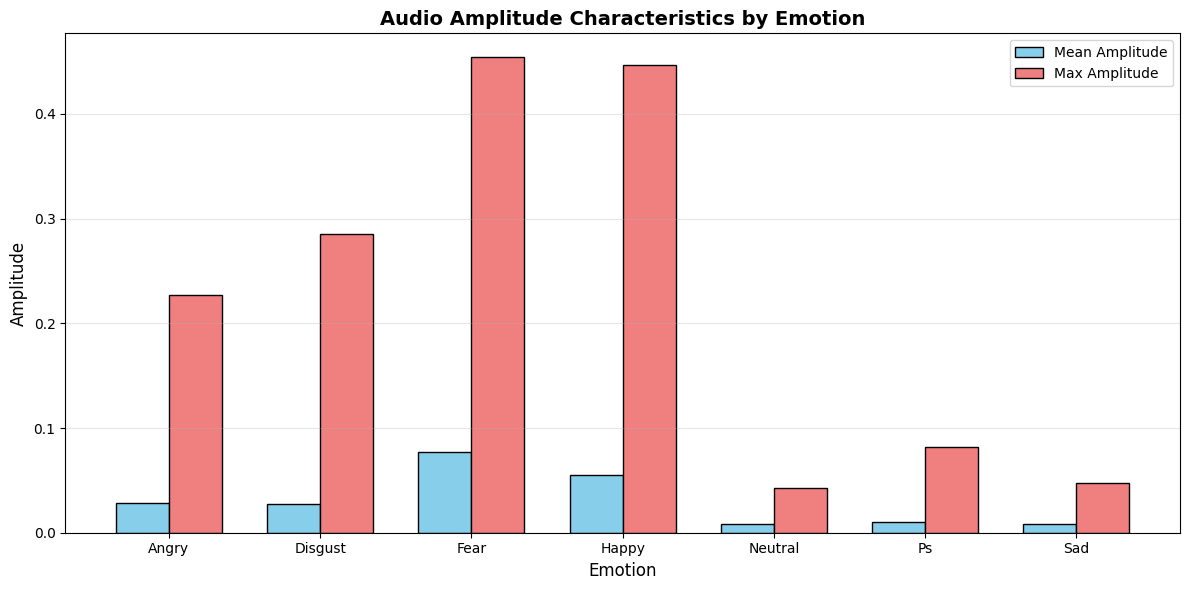

In [46]:
# Cell 46: Detailed Audio Feature Analysis for Sample Files

# Analyze one sample from each emotion
print("Analyzing sample audio files from each emotion class...\n")

sample_analysis = []

for emotion in le.classes_:
    # Get first sample of this emotion
    emotion_path = df[df['label'] == emotion]['speech'].iloc[0]
    
    # Load audio
    y, sr = librosa.load(emotion_path, duration=2.5, offset=0.6)
    
    # Calculate basic statistics
    duration = len(y) / sr
    mean_amplitude = np.mean(np.abs(y))
    max_amplitude = np.max(np.abs(y))
    zero_crossings = np.sum(librosa.zero_crossings(y))
    
    sample_analysis.append({
        'Emotion': emotion.capitalize(),
        'Duration (s)': f"{duration:.2f}",
        'Mean Amplitude': f"{mean_amplitude:.4f}",
        'Max Amplitude': f"{max_amplitude:.4f}",
        'Zero Crossings': zero_crossings
    })

analysis_df = pd.DataFrame(sample_analysis)
print("Audio Characteristics by Emotion:")
print(analysis_df.to_string(index=False))

# Visualize amplitude statistics
plt.figure(figsize=(12, 6))

emotions = [item['Emotion'] for item in sample_analysis]
mean_amps = [float(item['Mean Amplitude']) for item in sample_analysis]
max_amps = [float(item['Max Amplitude']) for item in sample_analysis]

x = np.arange(len(emotions))
width = 0.35

plt.bar(x - width/2, mean_amps, width, label='Mean Amplitude', color='skyblue', edgecolor='black')
plt.bar(x + width/2, max_amps, width, label='Max Amplitude', color='lightcoral', edgecolor='black')

plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title('Audio Amplitude Characteristics by Emotion', fontsize=14, fontweight='bold')
plt.xticks(x, emotions)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

LAYER-BY-LAYER MODEL ANALYSIS
 Layer #                  Name               Type Output Shape Parameters
       1                conv1d             Conv1D          N/A      1,536
       2   batch_normalization BatchNormalization          N/A      1,024
       3         max_pooling1d       MaxPooling1D          N/A          0
       4               dropout            Dropout          N/A          0
       5              conv1d_1             Conv1D          N/A    327,936
       6 batch_normalization_1 BatchNormalization          N/A      1,024
       7       max_pooling1d_1       MaxPooling1D          N/A          0
       8             dropout_1            Dropout          N/A          0
       9              conv1d_2             Conv1D          N/A    163,968
      10 batch_normalization_2 BatchNormalization          N/A        512
      11       max_pooling1d_2       MaxPooling1D          N/A          0
      12             dropout_2            Dropout          N/A          0
      13

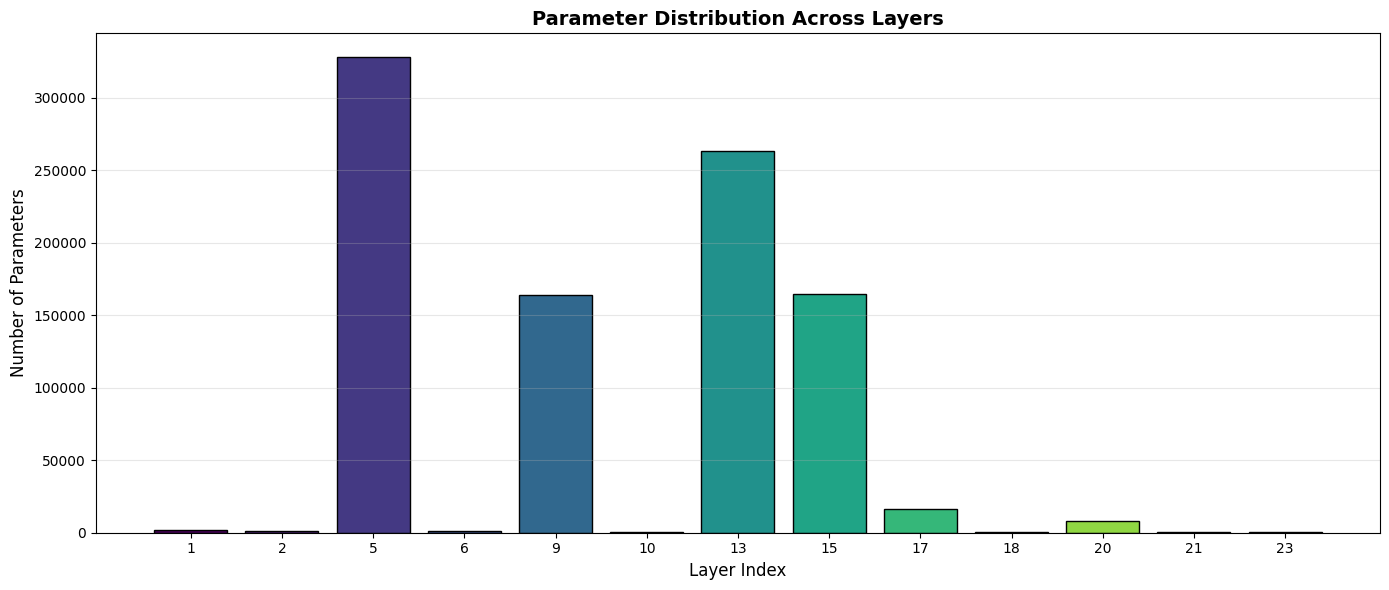

In [47]:
# Cell 47: Detailed Layer-by-Layer Model Analysis

print("LAYER-BY-LAYER MODEL ANALYSIS")
print("="*80)

layer_info = []
total_params = 0

for i, layer in enumerate(model.layers):
    layer_name = layer.name
    layer_type = layer.__class__.__name__
    
    # Get output shape
    try:
        output_shape = layer.output_shape
    except:
        output_shape = "N/A"
    
    # Get number of parameters
    params = layer.count_params()
    total_params += params
    
    layer_info.append({
        'Layer #': i + 1,
        'Name': layer_name,
        'Type': layer_type,
        'Output Shape': str(output_shape),
        'Parameters': f"{params:,}"
    })

# Display as DataFrame
layer_df = pd.DataFrame(layer_info)
print(layer_df.to_string(index=False))

# Calculate trainable parameters correctly
trainable_count = sum([np.prod(w.shape) for w in model.trainable_weights])
non_trainable_count = sum([np.prod(w.shape) for w in model.non_trainable_weights])

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_count:,}")
print(f"Non-trainable Parameters: {non_trainable_count:,}")

# Visualize parameter distribution
param_counts = [int(item['Parameters'].replace(',', '')) for item in layer_info if int(item['Parameters'].replace(',', '')) > 0]
layer_indices = [item['Layer #'] for item in layer_info if int(item['Parameters'].replace(',', '')) > 0]

if len(param_counts) > 0:
    plt.figure(figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(param_counts)))
    plt.bar(range(len(param_counts)), param_counts, color=colors, edgecolor='black')
    plt.xlabel('Layer Index', fontsize=12)
    plt.ylabel('Number of Parameters', fontsize=12)
    plt.title('Parameter Distribution Across Layers', fontsize=14, fontweight='bold')
    plt.xticks(range(len(param_counts)), layer_indices)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

Prediction Distribution Analysis:
Emotion  True Count  Predicted Count
  angry          60               61
disgust          60               64
   fear          60               59
  happy          60               66
neutral          60               61
     ps          60               51
    sad          60               58


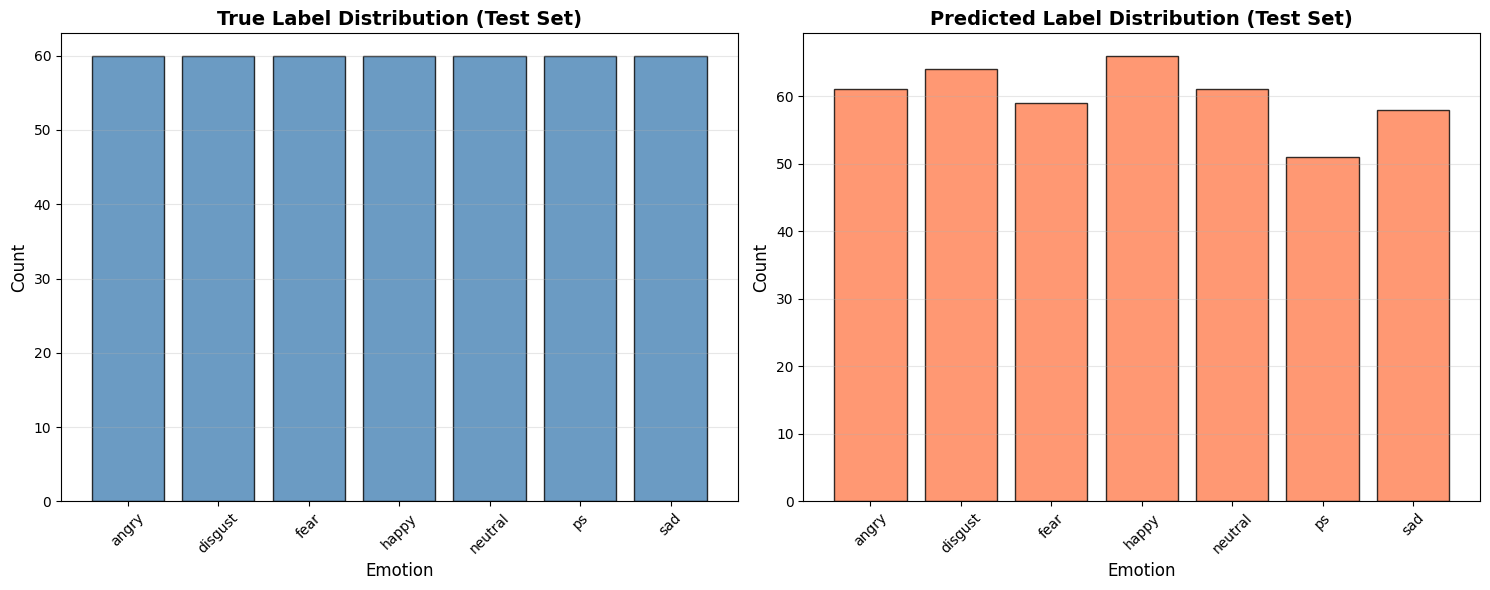


Prediction Bias Analysis:
  Angry       :  +1 ( +1.67%)
  Disgust     :  +4 ( +6.67%)
  Fear        :  -1 ( -1.67%)
  Happy       :  +6 (+10.00%)
  Neutral     :  +1 ( +1.67%)
  Ps          :  -9 (-15.00%)
  Sad         :  -2 ( -3.33%)


In [48]:
# Cell 48: Analyze Prediction Distribution Across Classes

# Count predictions per class
pred_distribution = pd.Series([le.classes_[i] for i in y_pred]).value_counts()
true_distribution = pd.Series([le.classes_[i] for i in y_true]).value_counts()

# Create comparison DataFrame
dist_df = pd.DataFrame({
    'Emotion': le.classes_,
    'True Count': [true_distribution.get(e, 0) for e in le.classes_],
    'Predicted Count': [pred_distribution.get(e, 0) for e in le.classes_]
})

print("Prediction Distribution Analysis:")
print(dist_df.to_string(index=False))

# Visualize distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# True distribution
axes[0].bar(dist_df['Emotion'], dist_df['True Count'], color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_title('True Label Distribution (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Predicted distribution
axes[1].bar(dist_df['Emotion'], dist_df['Predicted Count'], color='coral', edgecolor='black', alpha=0.8)
axes[1].set_title('Predicted Label Distribution (Test Set)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Emotion', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate prediction bias
print("\nPrediction Bias Analysis:")
for emotion in le.classes_:
    true_count = dist_df[dist_df['Emotion'] == emotion]['True Count'].values[0]
    pred_count = dist_df[dist_df['Emotion'] == emotion]['Predicted Count'].values[0]
    bias = pred_count - true_count
    bias_pct = (bias / true_count * 100) if true_count > 0 else 0
    print(f"  {emotion.capitalize():12s}: {bias:+3d} ({bias_pct:+6.2f}%)")

count params has an issue 

Performance at Different Confidence Thresholds:
 Threshold Coverage Accuracy  Samples
      0.50   99.76%   96.90%      419
      0.60   99.05%   97.12%      416
      0.70   98.10%   98.06%      412
      0.80   95.71%   98.76%      402
      0.90   92.38%   99.23%      388
      0.95   87.14%   99.45%      366


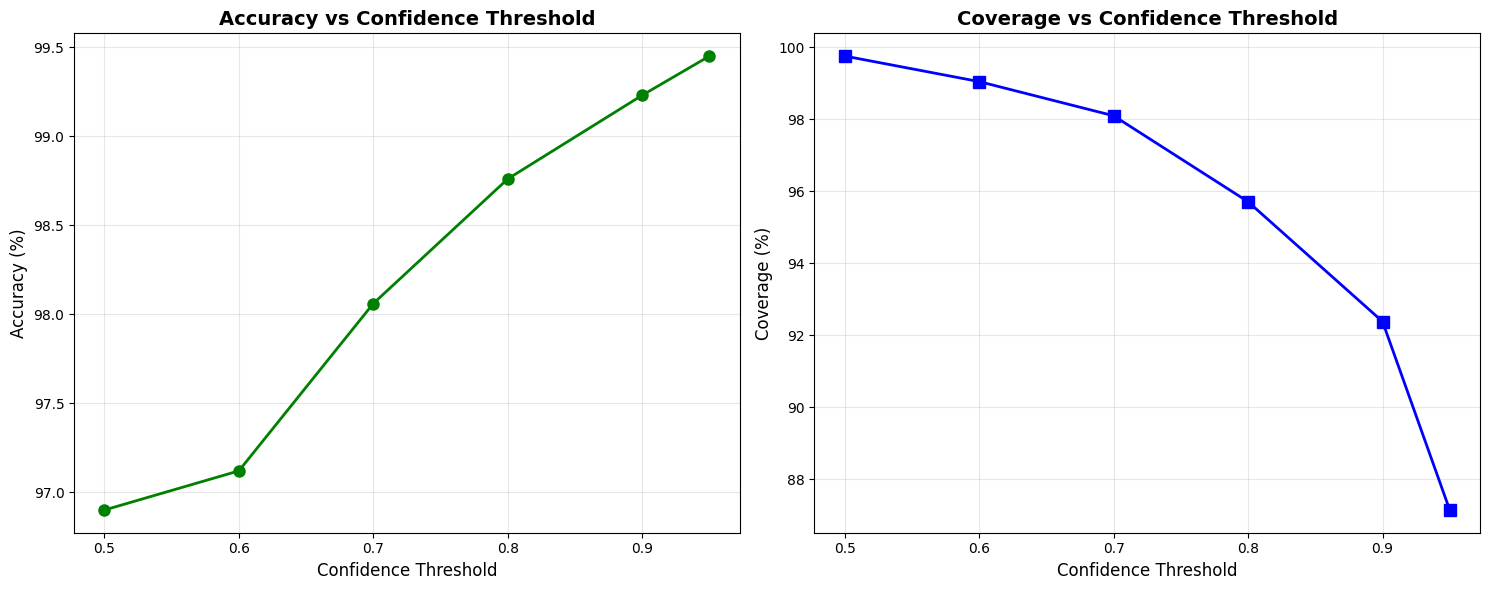

In [49]:
# Cell 49: Analyze Model Performance at Different Confidence Thresholds

confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
threshold_analysis = []

for threshold in confidence_thresholds:
    # Filter predictions by confidence
    confident_mask = max_confidences >= threshold
    
    if np.sum(confident_mask) > 0:
        confident_correct = np.sum((y_pred[confident_mask] == y_true[confident_mask]))
        confident_total = np.sum(confident_mask)
        confident_accuracy = confident_correct / confident_total
        coverage = confident_total / len(y_test)
    else:
        confident_accuracy = 0
        coverage = 0
    
    threshold_analysis.append({
        'Threshold': threshold,
        'Coverage': f"{coverage * 100:.2f}%",
        'Accuracy': f"{confident_accuracy * 100:.2f}%",
        'Samples': np.sum(confident_mask)
    })

threshold_df = pd.DataFrame(threshold_analysis)
print("Performance at Different Confidence Thresholds:")
print(threshold_df.to_string(index=False))

# Visualize threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

thresholds = [t['Threshold'] for t in threshold_analysis]
accuracies = [float(t['Accuracy'].rstrip('%')) for t in threshold_analysis]
coverages = [float(t['Coverage'].rstrip('%')) for t in threshold_analysis]

# Accuracy vs Threshold
axes[0].plot(thresholds, accuracies, marker='o', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Confidence Threshold', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy vs Confidence Threshold', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Coverage vs Threshold
axes[1].plot(thresholds, coverages, marker='s', linewidth=2, markersize=8, color='blue')
axes[1].set_xlabel('Confidence Threshold', fontsize=12)
axes[1].set_ylabel('Coverage (%)', fontsize=12)
axes[1].set_title('Coverage vs Confidence Threshold', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Top 10 Most Confused Emotion Pairs:
True Emotion Predicted As  Count Confusion Rate
          Ps        Happy      5          8.33%
          Ps      Disgust      3          5.00%
       Angry        Happy      1          1.67%
        Fear        Angry      1          1.67%
          Ps        Angry      1          1.67%
         Sad      Disgust      1          1.67%
         Sad      Neutral      1          1.67%


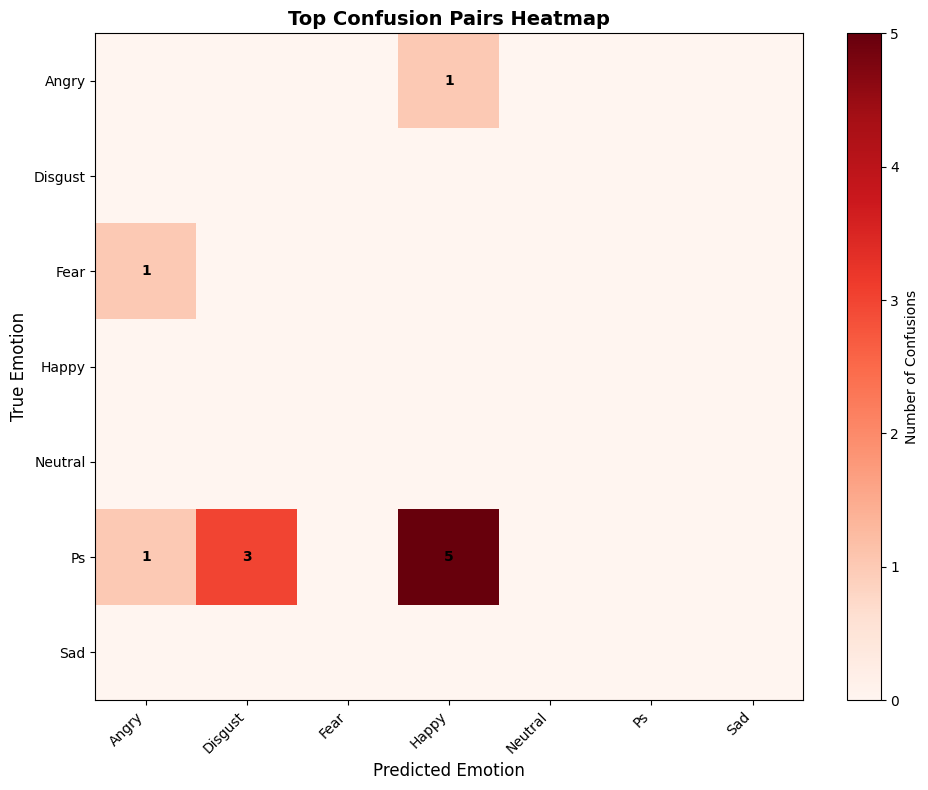

In [50]:
# Cell 50: Analyze Which Emotion Pairs Are Most Confused

# Create confusion pair matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Calculate confusion rates (normalize by row)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Find top confused pairs (excluding diagonal)
confused_pairs = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j:  # Exclude correct predictions
            confusion_rate = cm_normalized[i, j]
            count = cm[i, j]
            if count > 0:
                confused_pairs.append({
                    'True Emotion': le.classes_[i].capitalize(),
                    'Predicted As': le.classes_[j].capitalize(),
                    'Count': count,
                    'Confusion Rate': f"{confusion_rate * 100:.2f}%"
                })

# Sort by count
confused_pairs.sort(key=lambda x: x['Count'], reverse=True)

print("Top 10 Most Confused Emotion Pairs:")
if len(confused_pairs) > 0:
    confused_df = pd.DataFrame(confused_pairs[:10])
    print(confused_df.to_string(index=False))
else:
    print("No confusion found - perfect classification!")

# Visualize confusion network
if len(confused_pairs) > 0:
    top_pairs = confused_pairs[:5]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a simplified visualization
    emotions = le.classes_
    y_pos = np.arange(len(emotions))
    
    # Create heatmap of top confusions
    confusion_matrix_viz = np.zeros((len(emotions), len(emotions)))
    for pair in top_pairs:
        true_idx = list(emotions).index(pair['True Emotion'].lower())
        pred_idx = list(emotions).index(pair['Predicted As'].lower())
        confusion_matrix_viz[true_idx, pred_idx] = pair['Count']
    
    im = ax.imshow(confusion_matrix_viz, cmap='Reds', aspect='auto')
    
    ax.set_xticks(y_pos)
    ax.set_yticks(y_pos)
    ax.set_xticklabels([e.capitalize() for e in emotions], rotation=45, ha='right')
    ax.set_yticklabels([e.capitalize() for e in emotions])
    
    # Add text annotations
    for i in range(len(emotions)):
        for j in range(len(emotions)):
            if confusion_matrix_viz[i, j] > 0:
                text = ax.text(j, i, int(confusion_matrix_viz[i, j]),
                             ha="center", va="center", color="black", fontweight='bold')
    
    ax.set_xlabel('Predicted Emotion', fontsize=12)
    ax.set_ylabel('True Emotion', fontsize=12)
    ax.set_title('Top Confusion Pairs Heatmap', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Number of Confusions')
    plt.tight_layout()
    plt.show()

Training Convergence Analysis:
Total Epochs Run:           96
Best Epoch:                 85
Best Validation Accuracy:   96.67%
Final Training Accuracy:    95.05%
Final Validation Accuracy:  96.19%
Accuracy Improvement Rate:  0.8014% per epoch
Loss Reduction Rate:        0.0280 per epoch


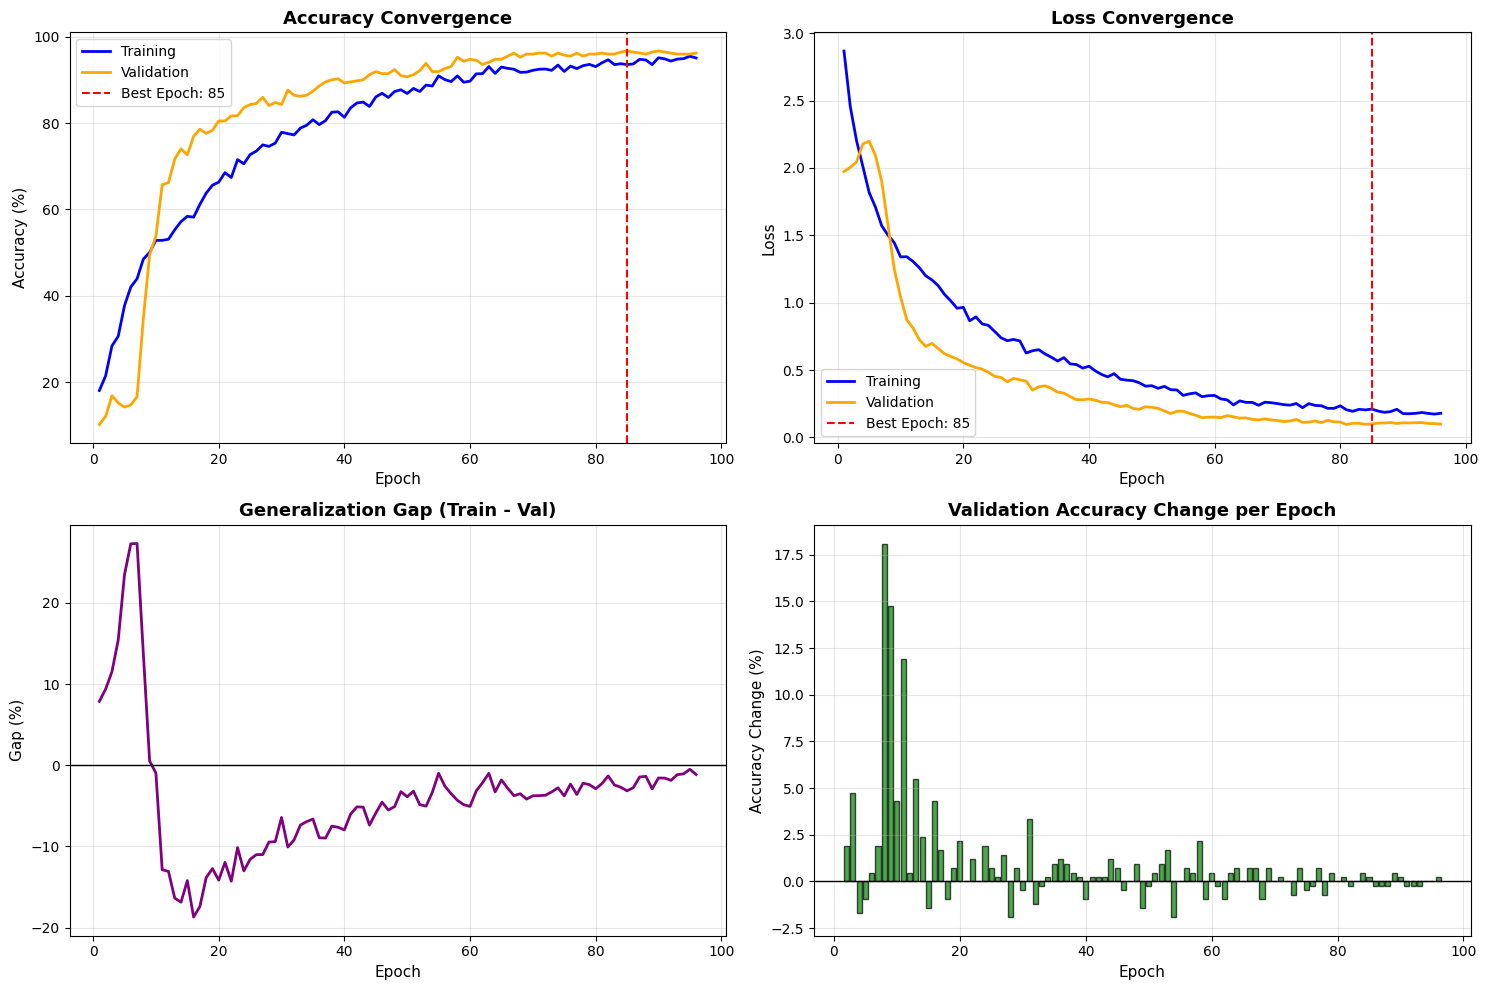

In [51]:
# Cell 51: Analyze Training Convergence Patterns

# Calculate epoch-wise metrics
epochs = range(1, len(history.history['loss']) + 1)
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Find best epoch
best_epoch = np.argmax(val_acc) + 1
best_val_acc = np.max(val_acc)

# Calculate convergence metrics
acc_improvement_rate = (train_acc[-1] - train_acc[0]) / len(epochs)
loss_reduction_rate = (train_loss[0] - train_loss[-1]) / len(epochs)

print("Training Convergence Analysis:")
print(f"Total Epochs Run:           {len(epochs)}")
print(f"Best Epoch:                 {best_epoch}")
print(f"Best Validation Accuracy:   {best_val_acc * 100:.2f}%")
print(f"Final Training Accuracy:    {train_acc[-1] * 100:.2f}%")
print(f"Final Validation Accuracy:  {val_acc[-1] * 100:.2f}%")
print(f"Accuracy Improvement Rate:  {acc_improvement_rate * 100:.4f}% per epoch")
print(f"Loss Reduction Rate:        {loss_reduction_rate:.4f} per epoch")

# Plot convergence patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy over time
axes[0, 0].plot(epochs, train_acc * 100, label='Training', linewidth=2, color='blue')
axes[0, 0].plot(epochs, val_acc * 100, label='Validation', linewidth=2, color='orange')
axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 0].set_title('Accuracy Convergence', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss over time
axes[0, 1].plot(epochs, train_loss, label='Training', linewidth=2, color='blue')
axes[0, 1].plot(epochs, val_loss, label='Validation', linewidth=2, color='orange')
axes[0, 1].axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Loss Convergence', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Generalization gap
gap = (train_acc - val_acc) * 100
axes[1, 0].plot(epochs, gap, linewidth=2, color='purple')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Gap (%)', fontsize=11)
axes[1, 0].set_title('Generalization Gap (Train - Val)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Improvement rate
acc_changes = np.diff(val_acc) * 100
axes[1, 1].bar(range(2, len(epochs) + 1), acc_changes, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Accuracy Change (%)', fontsize=11)
axes[1, 1].set_title('Validation Accuracy Change per Epoch', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


COMPREHENSIVE METRICS SUMMARY

ACCURACY METRICS
  Training Accuracy:        97.30%
  Validation Accuracy:      96.19%
  Test Accuracy:            96.90%
  Train-Val Gap:            1.11%
  Val-Test Gap:             0.71%

PRECISION METRICS (Test Set)
  Macro Average:            0.9711
  Weighted Average:         0.9711

RECALL METRICS (Test Set)
  Macro Average:            0.9690
  Weighted Average:         0.9690

F1-SCORE METRICS (Test Set)
  Macro Average:            0.9687
  Weighted Average:         0.9687

LOSS METRICS
  Training Loss:            2.8678
  Validation Loss:          1.9737
  Test Loss:                0.0817

CONFIDENCE METRICS
  Mean Confidence:          0.9722
  Median Confidence:        0.9967
  Min Confidence:           0.4896
  Max Confidence:           0.9999

MODEL COMPLEXITY
  Total Parameters:         949,511
  Total Layers:             23
  Input Features:           195

TRAINING CONFIGURATION
  Epochs Completed:         96
  Best Epoch:               85


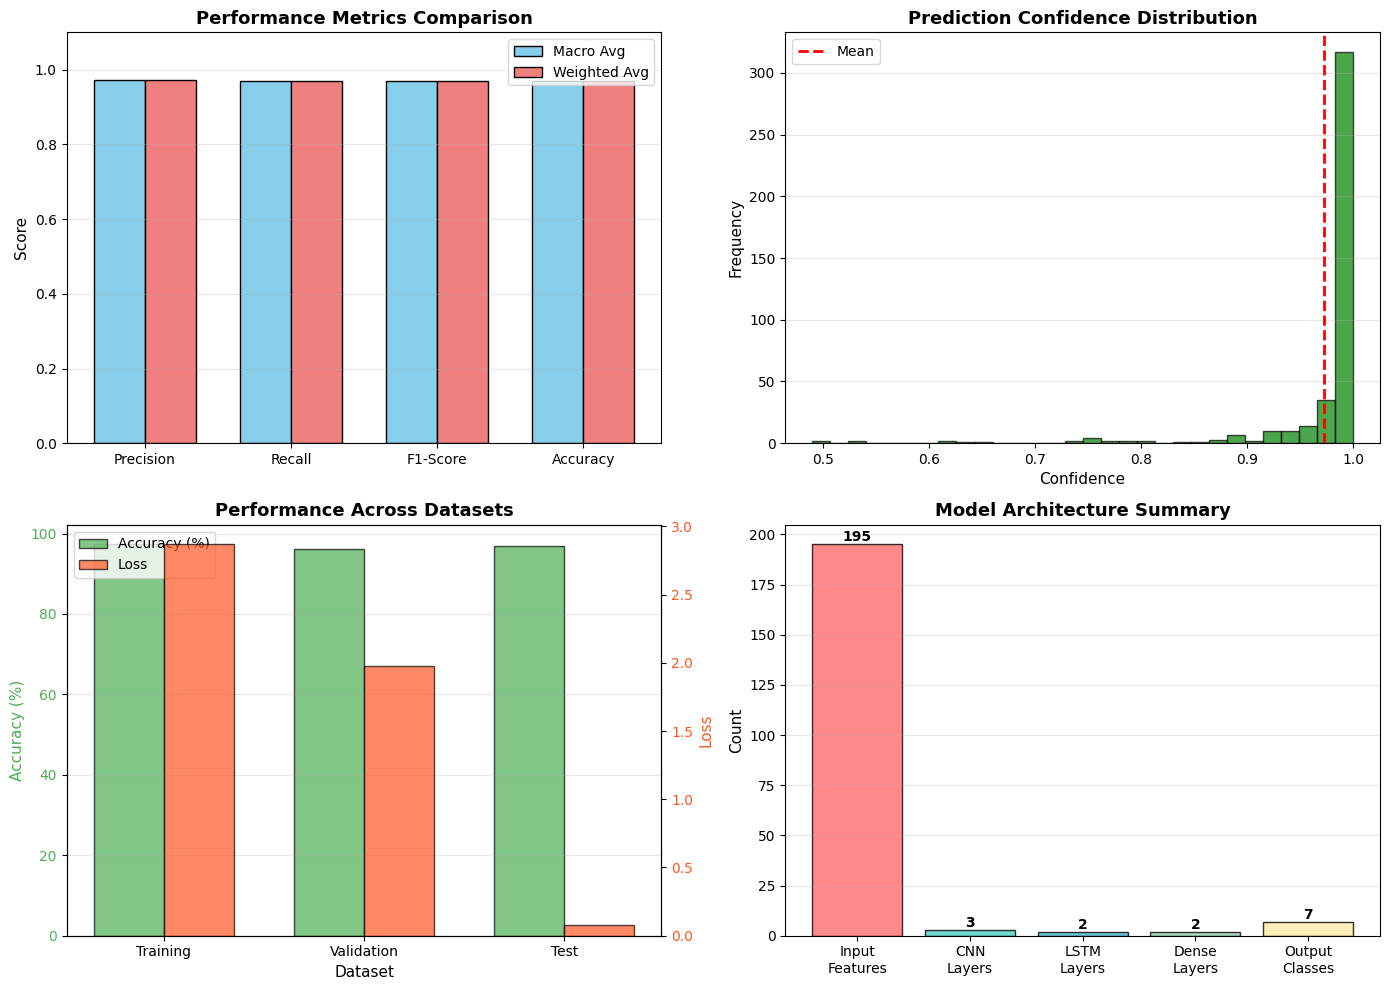

In [52]:
# Cell 52: Comprehensive Metrics Summary

from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate macro and weighted averages
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# Extract scalar values - handle both scalars and arrays
def get_scalar(value):
    if isinstance(value, (int, float)):
        return value
    else:
        arr = np.asarray(value).flatten()
        return arr[0] if len(arr) > 0 else value

train_loss_val = get_scalar(train_loss)
val_loss_val = get_scalar(val_loss)
test_loss_val = get_scalar(test_loss)

print("\nCOMPREHENSIVE METRICS SUMMARY")

print("\nACCURACY METRICS")
print(f"  Training Accuracy:        {train_accuracy * 100:.2f}%")
print(f"  Validation Accuracy:      {val_accuracy * 100:.2f}%")
print(f"  Test Accuracy:            {test_accuracy * 100:.2f}%")
print(f"  Train-Val Gap:            {abs(train_accuracy - val_accuracy) * 100:.2f}%")
print(f"  Val-Test Gap:             {abs(val_accuracy - test_accuracy) * 100:.2f}%")

print("\nPRECISION METRICS (Test Set)")
print(f"  Macro Average:            {precision_macro:.4f}")
print(f"  Weighted Average:         {precision_weighted:.4f}")

print("\nRECALL METRICS (Test Set)")
print(f"  Macro Average:            {recall_macro:.4f}")
print(f"  Weighted Average:         {recall_weighted:.4f}")

print("\nF1-SCORE METRICS (Test Set)")
print(f"  Macro Average:            {f1_macro:.4f}")
print(f"  Weighted Average:         {f1_weighted:.4f}")

print("\nLOSS METRICS")
print(f"  Training Loss:            {train_loss_val:.4f}")
print(f"  Validation Loss:          {val_loss_val:.4f}")
print(f"  Test Loss:                {test_loss_val:.4f}")

print("\nCONFIDENCE METRICS")
print(f"  Mean Confidence:          {np.mean(max_confidences):.4f}")
print(f"  Median Confidence:        {np.median(max_confidences):.4f}")
print(f"  Min Confidence:           {np.min(max_confidences):.4f}")
print(f"  Max Confidence:           {np.max(max_confidences):.4f}")

print("\nMODEL COMPLEXITY")
print(f"  Total Parameters:         {model.count_params():,}")
print(f"  Total Layers:             {len(model.layers)}")
print(f"  Input Features:           {X.shape[1]}")

print("\nTRAINING CONFIGURATION")
print(f"  Epochs Completed:         {len(history.history['loss'])}")
print(f"  Best Epoch:               {np.argmax(history.history['val_accuracy']) + 1}")
print(f"  Batch Size:               32")
print(f"  Learning Rate:            0.0001 (initial)")

print("\nDATASET SPLIT")
print(f"  Training:                 {len(X_train)} samples (70%)")
print(f"  Validation:               {len(X_val)} samples (15%)")
print(f"  Test:                     {len(X_test)} samples (15%)")

print("\nANALYSIS COMPLETE\n")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Metric comparison
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
macro_scores = [precision_macro, recall_macro, f1_macro, test_accuracy]
weighted_scores = [precision_weighted, recall_weighted, f1_weighted, test_accuracy]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, macro_scores, width, label='Macro Avg', color='skyblue', edgecolor='black')
axes[0, 0].bar(x + width/2, weighted_scores, width, label='Weighted Avg', color='lightcoral', edgecolor='black')
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1.1])

# Confidence distribution
axes[0, 1].hist(max_confidences, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(np.mean(max_confidences), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].set_xlabel('Confidence', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Prediction Confidence Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Train vs Validation vs Test performance
datasets = ['Training', 'Validation', 'Test']
accuracies_plot = [train_accuracy * 100, val_accuracy * 100, test_accuracy * 100]
losses_plot = [train_loss_val, val_loss_val, test_loss_val]

x_pos = np.arange(len(datasets))
width = 0.35

ax_twin = axes[1, 0].twinx()
bars1 = axes[1, 0].bar(x_pos - width/2, accuracies_plot, width, label='Accuracy (%)', 
                       color='#4CAF50', edgecolor='black', alpha=0.7)
bars2 = ax_twin.bar(x_pos + width/2, losses_plot, width, label='Loss', 
                    color='#FF5722', edgecolor='black', alpha=0.7)

axes[1, 0].set_ylabel('Accuracy (%)', fontsize=11, color='#4CAF50')
ax_twin.set_ylabel('Loss', fontsize=11, color='#FF5722')
axes[1, 0].set_xlabel('Dataset', fontsize=11)
axes[1, 0].set_title('Performance Across Datasets', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(datasets)
axes[1, 0].tick_params(axis='y', labelcolor='#4CAF50')
ax_twin.tick_params(axis='y', labelcolor='#FF5722')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add legend
lines1, labels1 = axes[1, 0].get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
axes[1, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Model architecture summary
components = ['Input\nFeatures', 'CNN\nLayers', 'LSTM\nLayers', 'Dense\nLayers', 'Output\nClasses']
values = [X.shape[1], 3, 2, 2, len(le.classes_)]
colors_list = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

axes[1, 1].bar(components, values, color=colors_list, edgecolor='black', alpha=0.8)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Model Architecture Summary', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (comp, val) in enumerate(zip(components, values)):
    axes[1, 1].text(i, val, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()